In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
import datatable as dt
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import shap
import UQ_toolbox as uq
from PIL import Image
from skimage import io
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
try:
    num_gpus = torch.cuda.device_count()
    print("Number of GPUs available:", num_gpus)
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
except Exception as e:
    print("Error while checking GPUs:", e)
    
print(torch.cuda.is_available())
device = torch.device("cuda:2")

Number of GPUs available: 3
GPU 0: NVIDIA RTX A6000
GPU 1: NVIDIA RTX A6000
GPU 2: NVIDIA RTX A6000
True


In [3]:
# CNN model
class simpleNet(nn.Module):
    def __init__(self):
        super(simpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout_conv = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*12*12, 64)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x= self.dropout_conv(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout_conv(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [4]:
class ToTensor(object):
    def __call__(self, sample):
        image, shape, img_name = sample['image'], sample['shape'], sample['name']
        if shape=='Round':
            shape=0
        elif shape=='Irregular':
            shape=1
        elif shape=='Ambiguous':
            shape=2
        return {'image': torch.from_numpy(image).unsqueeze(0),
                'shape': torch.from_numpy(np.asarray(shape)),
                'name': img_name}

In [5]:
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, sample):
        image, shape, img_name = sample['image'], sample['shape'], sample['name']
        norm = transforms.Normalize(mean=self.mean, std=self.std)
        return {'image': norm(image.float()),
                'shape': shape,            
                'name': img_name}

In [6]:
# Load the models
model_paths = ['model_shape_0_augmented.pt', 'model_shape_1_augmented.pt', 'model_shape_2_augmented.pt', 'model_shape_3_augmented.pt', 'model_shape_4_augmented.pt']
models_list = []
path_to_models = './models/'
for path in model_paths:
    model = simpleNet()
    model.load_state_dict(torch.load(path_to_models + path, map_location=device))
    model.eval()  # Set the model to evaluation mode
    models_list.append(model)

In [7]:
class AxialCutsDataset(Dataset):

    def __init__(self, data_shape, transform=None, for_trainning=False, mean=False, std=False, downsample=False):
        self.data = data_shape
        self.transform=transform
        self.for_trainning = for_trainning
        self.mean= mean
        self.std = std
        self.downsample = downsample

        if self.downsample:
            df_majority = self.data[self.data.iloc[:, 1]=='Irregular']
            df_majority_downsampled = resample(df_majority, replace=False, n_samples=1200, random_state=125)
            self.data = pd.concat((self.data[self.data['Shape'] != 'Irregular'], df_majority_downsampled))

    def __len__(self):
        return len(self.data.iloc[:, 0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.data.iloc[idx, 0]
        image = io.imread(img_name)
        shape = self.data.iloc[idx, 1]
        sample = {'image': image, 'shape': shape, 'name':img_name}

        if self.transform:
            sample = self.transform(sample)

        return sample
        


In [8]:
# Define functions for evaluation metrics
def accuracy(outputs, labels):
    preds = outputs > 0.5 
    return accuracy_score(labels, preds)

def f1(outputs, labels):
    preds = outputs > 0.5
    return f1_score(labels, preds, average='binary')

def calculate_sensitivity(outputs, labels):
    preds = outputs > 0.5
    return recall_score(labels, preds, average='binary')

def roc_auc(outputs, labels):
    probs = outputs
    return roc_auc_score(labels, probs)

def compute_confusion_matrix(outputs, labels):
    preds = outputs > 0.5
    return confusion_matrix(labels, preds)

def calculate_specificity(cm):
    TN = cm[0, 0]  # True negatives
    FP = cm[0, 1]  # False positives
    return TN / (TN + FP)

In [9]:
def display_confusion_matrix(cm):
    # Define class names
    class_names = ['Round', 'Irregular']
    
    # Create a DataFrame for better visualization
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 30})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [10]:
def calculate_val_metrics(all_preds, all_labels):

    # Compute evaluation metrics
    acc = accuracy(all_preds, all_labels)
    f1_result = f1(all_preds, all_labels)
    roc_auc_result = roc_auc(all_preds, all_labels)
    cm = compute_confusion_matrix(all_preds, all_labels)
    display_confusion_matrix(cm)
    sensitivity_value = calculate_sensitivity(all_preds, all_labels)
    specificity_value = calculate_specificity(cm)

    print('Accuracy: {:.6f} \tF1 Score: {:.6f} \tROC AUC: {:.6f} \tSpecificity: {:.6f} \tSensitivity: {:.6f}'.format(
        acc, f1_result, roc_auc_result, specificity_value, sensitivity_value))

In [11]:
# Function to make predictions
def predict(models, image):
    image = image.to(device)
    predictions = [model(image).cpu().detach().numpy() for model in models]
    return predictions

In [12]:
def plot_tumor_predictions_with_percentages(data, shape_df):

    # Process and aggregate data for the bar plot
    tumor_data = {}
    
    for entry in data:
        img_name = entry['img_name']
        predicted_class = entry['predicted_class']
        # Extract patient (tumor) number and cut number from the image name
        tumor_id, cut_id_with_ext = img_name.split('/')[-1].split('_')[:2]
        cut_id = cut_id_with_ext.split('.')[0]  # Remove .png extension
        
        if tumor_id not in tumor_data:
            tumor_data[tumor_id] = []
        
        # Add predicted class (0 for round, 1 for irregular) to tumor's list
        tumor_data[tumor_id].append((int(cut_id), predicted_class))
    
    # Sort cuts by their axial number within each tumor
    for tumor_id in tumor_data:
        tumor_data[tumor_id].sort(key=lambda x: x[0])
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(8, 10))
    
    # For each tumor, create a row of colored bars based on the axial cut predictions
    y_positions = np.arange(len(tumor_data))
    
    for i, (tumor_id, cuts) in enumerate(sorted(tumor_data.items())):
     
        # Extract cut numbers and predicted classes
        cut_ids, predicted_classes = zip(*cuts)
        
        # Create a color map: red for 'Round' (class 0) and blue for 'Irregular' (class 1)
        colors = ['red' if pred == 0 else 'blue' for pred in predicted_classes]
        
        # Initialize variables to keep track of blocks of the same color
        current_color = colors[0]
        block_start = cut_ids[0]
        block_count = 1
        
        total_cuts = len(cuts)
        
        for j in range(1, total_cuts):
            if colors[j] == current_color:
                # Continue the current block
                block_count += 1
            else:
                # End the current block, plot it
                ax.barh(i, block_count, left=block_start, height=0.8, color=current_color)
                
                # Calculate the percentage for the block
                percentage = (block_count / total_cuts) * 100
                
                # Add the percentage as text in the middle of the block
                ax.text(block_start + block_count / 2, i, f'{percentage:.1f}%', va='center', ha='center', color='white')
                
                # Start a new block
                current_color = colors[j]
                block_start = cut_ids[j]
                block_count = 1
        
        # Plot the final block
        ax.barh(i, block_count, left=block_start, height=0.8, color=current_color)
        percentage = (block_count / total_cuts) * 100
        ax.text(block_start + block_count / 2, i, f'{percentage:.1f}%', va='center', ha='center', color='white')
        
        # Get the shape from the dataframe based on the tumor ID
        try:
            shape_label = shape_df.loc[shape_df['Record_ID'] == int(tumor_id), 'Shape.1'].values[0]
        except IndexError:
            shape_label = 'Unknown'  # Assign a default value if not found

        # Add the shape label as text at the end of the bar
        ax.text(max(cut_ids) + 1, i, shape_label, va='center')
    
    ax.set_xlabel('Axial Cuts')
    ax.set_ylabel('Tumors')
    ax.set_title('Tumor Axial Cut Predictions with Percentages and Shape Labels')
    ax.set_yticks(y_positions)
    ax.set_yticklabels(sorted(tumor_data.keys()))
    
    plt.tight_layout()
    plt.show()


In [13]:
def classify_tumors_by_contingent_blocks_with_sorting(data, shape_df, threshold=60):
    y_true = []
    y_pred = []
    
    # Process and aggregate data for each tumor
    tumor_data = {}
    
    for entry in data:
        img_name = entry['img_name']
        predicted_class = entry['predicted_class']
        
        # Extract patient (tumor) number and cut number from the image name
        tumor_id, cut_id_with_ext = img_name.split('/')[-1].split('_')[:2]
        cut_id = int(cut_id_with_ext.split('.')[0])  # Remove .png extension and convert to integer for sorting
        
        if tumor_id not in tumor_data:
            tumor_data[tumor_id] = []
        
        # Append both cut_id and predicted class to ensure sorting
        tumor_data[tumor_id].append((cut_id, predicted_class))
    
    # Classify each tumor based on the largest contiguous block of "Round" cuts
    for tumor_id, cuts in tumor_data.items():
        # Sort cuts by cut_id to ensure the correct sequence
        cuts_sorted = sorted(cuts, key=lambda x: x[0])  # Sort by cut_id
        
        # Extract only the predicted classes from sorted data
        predicted_classes_sorted = [pred_class for _, pred_class in cuts_sorted]
        
        #print(f"Processing tumor ID: {tumor_id}")
        
        # Find the true label from the shape_df dataframe ('Shape.1' column)
        try:
            shape_label = shape_df.loc[shape_df['Record_ID'] == int(tumor_id), 'Shape.1'].values[0]
            true_label = 0 if shape_label == 'Round' else 1  # Convert 'Round' to 0, 'Irregular' to 1
            #print(f"True label (from Shape.1): {shape_label}, Converted to: {true_label}")
        except IndexError:
            #print(f"Tumor ID {tumor_id} not found in shape_df!")
            continue  # Skip if tumor_id not found in shape_df
        
        # Calculate the largest contiguous block of "Round" (class 0) cuts
        max_round_block = 0
        current_round_block = 0
        total_cuts = len(predicted_classes_sorted)
        
        for pred_class in predicted_classes_sorted:
            if pred_class == 0:
                current_round_block += 1
            else:
                current_round_block = 0
            max_round_block = max(max_round_block, current_round_block)
        
        round_percentage = (max_round_block / total_cuts) * 100
        #print(f"Largest contiguous round block: {max_round_block} out of {total_cuts} cuts ({round_percentage:.1f}%)")
        
        # Apply the classification rule: Round if any block is >= threshold, else Irregular
        predicted_label = 0 if round_percentage >= threshold else 1
        #print(f"Predicted label based on threshold: {predicted_label}")
        
        # Store true and predicted labels
        y_true.append(true_label)
        y_pred.append(predicted_label)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Compute balanced accuracy
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    
    # Compute sensitivity (recall for class 1, irregular)
    sensitivity = recall_score(y_true, y_pred, pos_label=1)
    
    # Compute specificity (recall for class 0, round)
    specificity = recall_score(y_true, y_pred, pos_label=0)
    
    return cm, bal_acc, sensitivity, specificity

mean = 87.42158495776914
std = 29.82248099334633

In [14]:
mean = 87.42158495776914
std = 29.82248099334633

In [15]:
# Evaluation Data
images_path = '/mnt/data/psteinmetz/neotex/data_CNN/model_evaluation/evaluation_IRM_villes/'
data = pd.concat(
    (
        pd.DataFrame(glob.glob(f'{images_path}*/*png')),
        pd.DataFrame(
            [x.split('/')[-1][:-4] for x in glob.glob(f'{images_path}*/*png')]
        ),
        pd.DataFrame(
            [k.split('/')[-2] for k in glob.glob(f'{images_path}*/*png')]
        ),
    ),
    axis=1,
)
data.columns = ['Path', 'ID', 'Shape']
data.set_index('ID', inplace=True)


axialcuts_dataset_eval = AxialCutsDataset(data_shape=data, downsample=False)
data_without_amb = axialcuts_dataset_eval.data[axialcuts_dataset_eval.data['Shape']!='Ambiguous']
data_amb = axialcuts_dataset_eval.data[axialcuts_dataset_eval.data['Shape']=='Ambiguous']

             Shape.1
Record_ID           
5          Irregular
15         Irregular
16             Round
20         Irregular
22             Round
29             Round
33         Irregular
44         Irregular
52         Irregular
56         Irregular
59         Irregular
61         Irregular
64         Irregular
65         Irregular
67         Irregular
70             Round
71         Irregular
73         Irregular
84             Round
86         Irregular
94         Irregular
Fold 0:
  Train: index=Shape.1
Irregular    60
Round        22
Name: count, dtype: int64
  Test:  index=Shape.1
Irregular    16
Round         5
Name: count, dtype: int64
             Shape.1
Record_ID           
8          Irregular
9              Round
12         Irregular
14             Round
19             Round
24         Irregular
46         Irregular
47         Irregular
49         Irregular
57         Irregular
58             Round
60         Irregular
76         Irregular
77         Irregular
78         

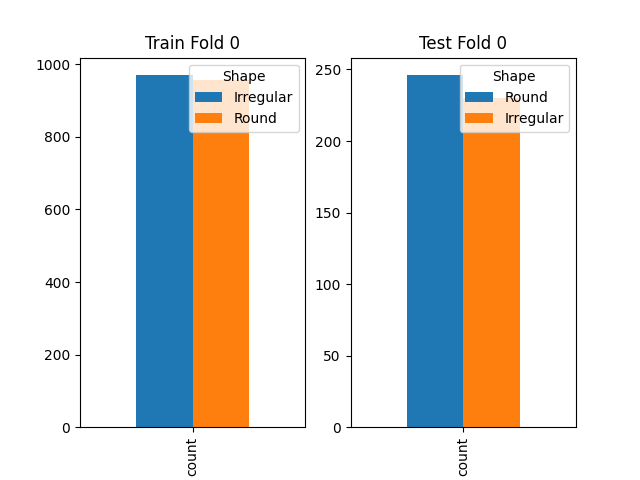

Shape
Round        1041
Irregular     889
Name: count, dtype: int64
Shape
Round        162
Irregular    162
Name: count, dtype: int64


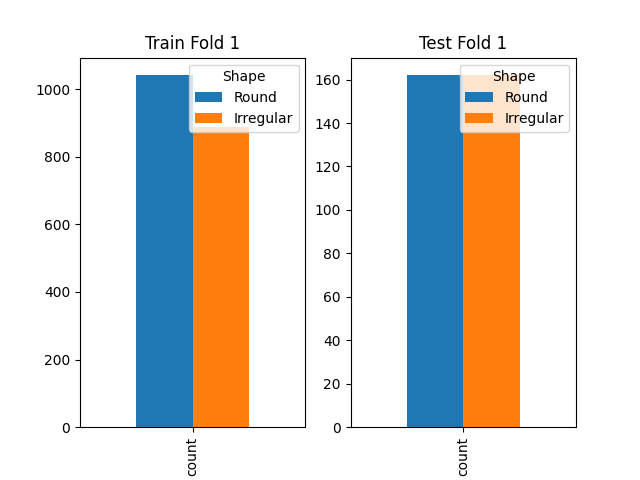

Shape
Round        978
Irregular    953
Name: count, dtype: int64
Shape
Irregular    247
Round        225
Name: count, dtype: int64


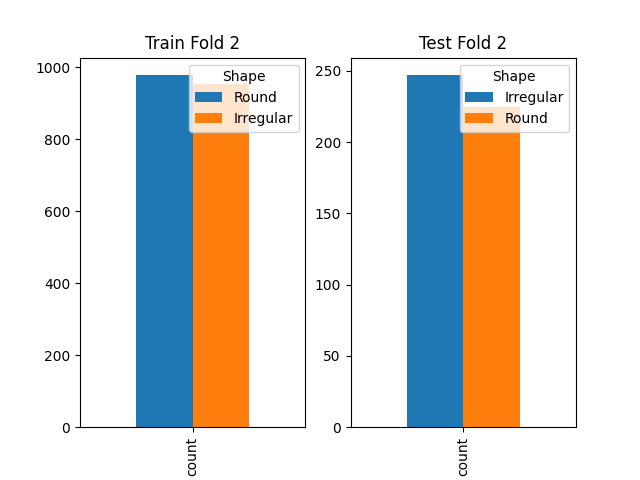

Shape
Round        988
Irregular    979
Name: count, dtype: int64
Shape
Irregular    221
Round        215
Name: count, dtype: int64


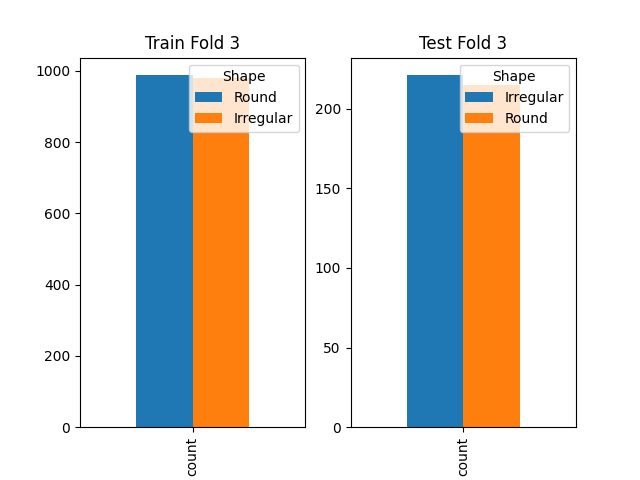

Shape
Irregular    1009
Round         848
Name: count, dtype: int64
Shape
Irregular    191
Round        191
Name: count, dtype: int64


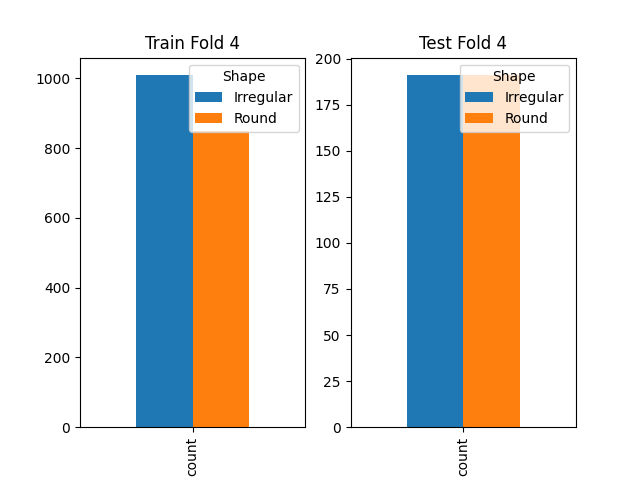

In [16]:
# Training Data

images_path_training_set = '/mnt/data/psteinmetz/neotex/data_CNN/images_15062024/'
data_training_set = pd.concat(
    (
        pd.DataFrame(glob.glob(f'{images_path_training_set}*/*png')),
        pd.DataFrame(
            [x.split('/')[-1][:-4] for x in glob.glob(f'{images_path_training_set}*/*png')]
        ),
        pd.DataFrame(
            [k.split('/')[-2] for k in glob.glob(f'{images_path_training_set}*/*png')]
        ),
    ),
    axis=1,
)
data_training_set.columns = ['Path', 'ID', 'Shape']
data_training_set.set_index('ID', inplace=True)
axialcuts_dataset_training_set = AxialCutsDataset(data_shape=data_training_set, downsample=True)

path_to_csv_training = r'/mnt/data/psteinmetz/neotex/CSV/BOUNDING_BOX.csv'
data_train = dt.fread(path_to_csv_training).to_pandas()
shape_target_train = pd.concat((data_train[['Record_ID']], data_train[['Shape.1']]), axis=1)
shape_modified = shape_target_train.replace('Oval', 'Round')

shape_modified.set_index('Record_ID', inplace=True)
list_cases, index = np.unique((pd.DataFrame(axialcuts_dataset_training_set.data.index)['ID'].apply(lambda x: x.split('_')[0])), return_index=True)
X = list_cases
y = np.array(shape_modified['Shape.1'])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(shape_modified.iloc[test_index])
    print(f"Fold {i}:")
    print(f"  Train: index={shape_modified.iloc[train_index]['Shape.1'].value_counts()}")

    print(f"  Test:  index={shape_modified.iloc[test_index]['Shape.1'].value_counts()}")
data_without_amb_train_set = axialcuts_dataset_training_set.data[axialcuts_dataset_training_set.data['Shape']!='Ambiguous']
serie = (pd.DataFrame(data_without_amb_train_set.index)['ID'].apply(lambda x: x.split('_')[0]))

train_folds_index = []
test_folds_index = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    ind_lists_train = [list(serie[serie==k].index[:].ravel()) for k in X[train_index]]
    flat_list_train = [
        x
        for xs in ind_lists_train
        for x in xs
        ]
    train_folds_index.append(flat_list_train)
    ind_lists_test = [list(serie[serie==k].index[:].ravel()) for k in X[test_index]]
    flat_list_test = [
        x
        for xs in ind_lists_test
        for x in xs
    ]
    
    a_train = data_without_amb_train_set.iloc[flat_list_train]['Shape'].value_counts().min()
    b_train = data_without_amb_train_set.iloc[flat_list_train]['Shape'].value_counts().max()
    
    a_test = data_without_amb_train_set.iloc[flat_list_test]['Shape'].value_counts().min()
    b_test = data_without_amb_train_set.iloc[flat_list_test]['Shape'].value_counts().max()
    
    if a_test/(a_test + b_test) < 0.4:
        label_maj = data_without_amb_train_set.iloc[flat_list_test]['Shape'].value_counts().idxmax()
        label_min = data_without_amb_train_set.iloc[flat_list_test]['Shape'].value_counts().idxmin()
        df_majority = data_without_amb_train_set.iloc[flat_list_test]['Shape'].loc[data_without_amb_train_set.iloc[flat_list_test]['Shape']==label_maj]
        df_majority_downsampled = resample(df_majority, replace=False, n_samples=a_test, random_state=125)
        
        index_list = data_without_amb_train_set.iloc[flat_list_test].loc[data_without_amb_train_set.iloc[flat_list_test]['Shape']==label_min].index
        row_numbers_min = [data_without_amb_train_set.index.get_loc(idx) for idx in index_list]
        
        flat_list_test = row_numbers_min + [data_without_amb_train_set.index.get_loc(idx) for idx in df_majority_downsampled.index]
    test_folds_index.append(flat_list_test)
    
    print(data_without_amb_train_set.iloc[flat_list_train]['Shape'].value_counts())
    print(data_without_amb_train_set.iloc[flat_list_test]['Shape'].value_counts())
    data_train = pd.DataFrame(data_without_amb_train_set.iloc[flat_list_train]['Shape'].value_counts())
    data_test = pd.DataFrame(data_without_amb_train_set.iloc[flat_list_test]['Shape'].value_counts())
    _, axs = plt.subplots(1, 2)
    data_train.T.plot.bar(title=f'Train Fold {str(i)}', ax=axs[0])
    data_test.T.plot.bar(title=f'Test Fold {str(i)}', ax=axs[1])
    
    plt.show()
    
normalized_datasets_train_set = []
means = []
stds = []
transformed_dataset = AxialCutsDataset(data_shape=data_training_set, downsample=True, transform= ToTensor())

for fold in range(0, 5):
    train_sampler = torch.utils.data.SubsetRandomSampler(train_folds_index[fold])
    
    new_dataloader = DataLoader(transformed_dataset, batch_size=1, num_workers=7, sampler=train_sampler)
    a=[k['image'] for k in new_dataloader]
    mean = np.mean(a)
    std = np.std(a)
    means.append(mean)
    stds.append(std)
    data_transforms = transforms.Compose([
        ToTensor(),
        Normalize(mean=mean, std=std)
    ])
    normalized_dataset_train_set = AxialCutsDataset(data_shape=data_without_amb_train_set, downsample=True, transform=data_transforms)
    normalized_datasets_train_set.append(normalized_dataset_train_set)

In [17]:
# Calibration Data

images_path_calibration = '/mnt/data/psteinmetz/neotex/data_CNN/images_Ozgun_for_calibration/'
data_calibration = pd.concat(
    (
        pd.DataFrame(glob.glob(f'{images_path_calibration}*/*png')),
        pd.DataFrame(
            [x.split('/')[-1][:-4] for x in glob.glob(f'{images_path_calibration}*/*png')]
        ),
        pd.DataFrame(
            [k.split('/')[-2] for k in glob.glob(f'{images_path_calibration}*/*png')]
        ),
    ),
    axis=1,
)
data_calibration.columns = ['Path', 'ID', 'Shape']
data_calibration.set_index('ID', inplace=True)


axialcuts_dataset_calibration = AxialCutsDataset(data_shape=data_calibration, downsample=False)
data_without_amb_calibration = axialcuts_dataset_calibration.data[axialcuts_dataset_calibration.data['Shape']!='Ambiguous']
data_amb_calibration = axialcuts_dataset_calibration.data[axialcuts_dataset_calibration.data['Shape']=='Ambiguous']

In [18]:
data_transforms = transforms.Compose([
    ToTensor(),
    Normalize(mean=mean, std=std)
])

In [19]:
data_without_amb_eval = AxialCutsDataset(data_shape=data_without_amb, downsample=False, transform=data_transforms)
data_amb_eval = AxialCutsDataset(data_shape=data_amb, downsample=False, transform=data_transforms)

eval_data = DataLoader(data_without_amb_eval, num_workers=12, batch_size=128, shuffle=False)
eval_data_amb = DataLoader(data_amb_eval, num_workers=12, batch_size=128, shuffle=False)

axialcuts_dataset_eval_all = AxialCutsDataset(data_shape=data, downsample=False, transform=data_transforms)
eval_all_data = DataLoader(axialcuts_dataset_eval_all, num_workers=12, batch_size=128, shuffle=False)

axialcuts_dataset_eval_gps = AxialCutsDataset(data_shape=data_without_amb, downsample=False, transform=False)
eval_data_gps = DataLoader(axialcuts_dataset_eval_gps, num_workers=12, batch_size=128, shuffle=False)

In [20]:
data_without_amb_calibration_all = AxialCutsDataset(data_shape=data_without_amb_calibration, downsample=False, transform=data_transforms)
calibration_data = DataLoader(data_without_amb_calibration_all, num_workers=12, batch_size=128, shuffle=False)

axialcuts_dataset_calibration_gps = AxialCutsDataset(data_shape=data_without_amb_calibration, downsample=False, transform=False)
calibration_data_gps = DataLoader(axialcuts_dataset_calibration_gps, num_workers=12, batch_size=128, shuffle=False)

In [21]:
models = [model.to(device) for model in models_list]

In [22]:
# Store results
all_results = []
mean_pred = []
true_labels = []
models = [model.to(device) for model in models_list]
# Inference
with torch.no_grad():
    for batch in eval_data:
        images = batch['image']
        labels = batch['shape']

        pred_probs = predict(models, images)
        mean_probs = np.mean(pred_probs, axis=0)
        std_probs = np.std(pred_probs, axis=0) 
        
        if eval_data.batch_size == 1:
            # Collect the results
            mean_pred.append(mean_probs.item())
            true_labels.append(labels.item())
            all_results.append({
                'true_label': labels.item(),
                'predicted_probabilities': pred_probs,
                'predicted_class': int(mean_probs > 0.5),
                'std': std_probs,
                'mean': mean_probs
            })
        else:
            for i in range(len(labels)):
                mean_pred.append(mean_probs[i])
                true_labels.append(labels[i].item())
                all_results.append({
                    'true_label': labels[i].item(),
                    'predicted_probabilities': [pred_probs[k][i] for k in range(len(models))],  # Pred probs for the i-th sample over 5 models
                    'predicted_class': int(mean_probs[i] > 0.5),
                    'std': float(std_probs[i]),
                    'mean': float(mean_probs[i])
                })

/tmp/ipykernel_11373/977081340.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'predicted_class': int(mean_probs[i] > 0.5),
/tmp/ipykernel_11373/977081340.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'std': float(std_probs[i]),
/tmp/ipykernel_11373/977081340.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'mean': float(mean_probs[i])


In [23]:
# Store results
all_results_calibration = []
mean_pred_calibration = []
true_labels_calibration = []
models = [model.to(device) for model in models_list]
# Inference
with torch.no_grad():
    for batch in calibration_data:
        images = batch['image']
        labels = batch['shape']

        pred_probs = predict(models, images)
        mean_probs = np.mean(pred_probs, axis=0)
        std_probs = np.std(pred_probs, axis=0) 
        
        if calibration_data.batch_size == 1:
            # Collect the results
            mean_pred_calibration.append(mean_probs.item())
            true_labels_calibration.append(labels.item())
            all_results_calibration.append({
                'true_label': labels.item(),
                'predicted_probabilities': pred_probs,
                'predicted_class': int(mean_probs > 0.5),
                'std': std_probs,
                'mean': mean_probs
            })
        else:
            for i in range(len(labels)):
                mean_pred_calibration.append(mean_probs[i])
                true_labels_calibration.append(labels[i].item())
                all_results_calibration.append({
                    'true_label': labels[i].item(),
                    'predicted_probabilities': [pred_probs[k][i] for k in range(len(models))],  # Pred probs for the i-th sample over 5 models
                    'predicted_class': int(mean_probs[i] > 0.5),
                    'std': float(std_probs[i]),
                    'mean': float(mean_probs[i])
                })

/tmp/ipykernel_11373/3834074889.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'predicted_class': int(mean_probs[i] > 0.5),
/tmp/ipykernel_11373/3834074889.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'std': float(std_probs[i]),
/tmp/ipykernel_11373/3834074889.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'mean': float(mean_probs[i])


In [24]:
good_idx = [k for k in range(len(all_results)) if all_results[k]['true_label'] == all_results[k]['predicted_class']]
bad_idx = [k for k in range(len(all_results)) if all_results[k]['true_label'] != all_results[k]['predicted_class']]

good_idx_calibration = [k for k in range(len(all_results_calibration)) if all_results_calibration[k]['true_label'] == all_results_calibration[k]['predicted_class']]
bad_idx_calibration = [k for k in range(len(all_results_calibration)) if all_results_calibration[k]['true_label'] != all_results_calibration[k]['predicted_class']]

In [25]:
models_pred = [[all_results[k]['predicted_probabilities'][i].ravel() for k in range(len(all_results))] for i in range(5)]
mean_ensembling_pred = [all_results[k]['mean'] for k in range(len(all_results))]

models_pred_calibration = [[all_results_calibration[k]['predicted_probabilities'][i].ravel() for k in range(len(all_results_calibration))] for i in range(5)]
mean_ensembling_pred_calibration = [all_results_calibration[k]['mean'] for k in range(len(all_results_calibration))]

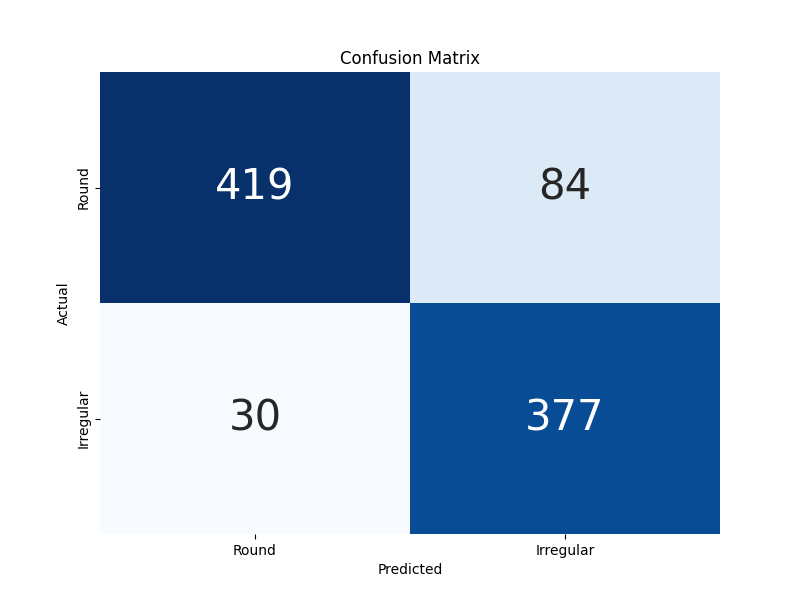

Accuracy: 0.874725 	F1 Score: 0.868664 	ROC AUC: 0.931722 	Specificity: 0.833002 	Sensitivity: 0.926290


In [26]:
calculate_val_metrics(np.array(mean_pred), np.array(true_labels))

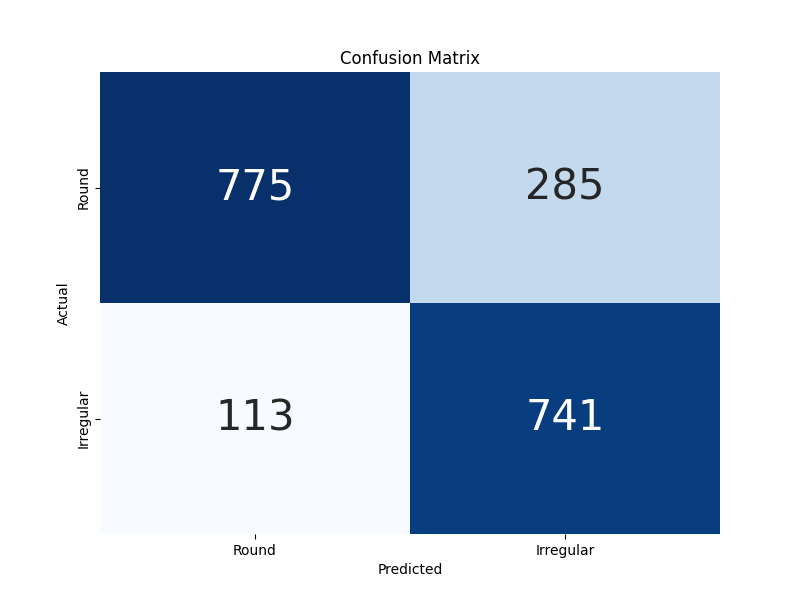

Accuracy: 0.792059 	F1 Score: 0.788298 	ROC AUC: 0.871131 	Specificity: 0.731132 	Sensitivity: 0.867681


In [27]:
calculate_val_metrics(np.array(mean_pred_calibration), np.array(true_labels_calibration))

In [28]:
def extract_latent_space(model, test_images, device=device, train_loader=None, layer_to_be_hooked=None):
    """
    Extracts latent space values from the final dense layer of a CNN dynamically.

    Args:
        model (torch.nn.Module): Pretrained CNN model.
        test_images (torch.Tensor or list): A single test image (C, H, W) or a batch of test images (N, C, H, W).
        train_loader (DataLoader): DataLoader for the training set.
        device (str): Device to run the computation ('cuda' or 'cpu').

    Returns:
        dict: Latent space representations for test images and the training set.
              Format: {'test': torch.Tensor, 'train': torch.Tensor}
    """
    
    # Find the penultimate layer dynamically
    def get_penultimate_layer(module):
        dense_layers = [
            (name, layer) for name, layer in model.named_modules()
            if isinstance(layer, nn.Linear)
        ]
        if len(dense_layers) < 2:
            raise ValueError("The model must have at least two fully connected (nn.Linear) layers.")
        return dense_layers[-2]  # Get the second to last dense layer
    
    if layer_to_be_hooked is None:
        penultimate_layer_name, penultimate_layer = get_penultimate_layer(model)
    else:
        penultimate_layer = model.layer_to_be_hooked

    # Hook to capture output of the penultimate layer
    latent_representation = None

    def get_latent_layer(module, input, output):
        nonlocal latent_representation
        latent_representation = output

    # Register forward hook on the penultimate layer
    hook = penultimate_layer.register_forward_hook(get_latent_layer)
    
    # Ensure test_images is a batch
    if isinstance(test_images, torch.Tensor) and len(test_images.shape) == 3:
        test_images = test_images.unsqueeze(0)  # Add batch dimension
    
    test_images = test_images.to(device)
    
    # Run the test images through the model
    with torch.no_grad():
        model(test_images)
        latent_test = latent_representation.cpu()

    if train_loader is not None:
        # Collect latent representations for the training set
        latent_train = []
        with torch.no_grad():
            for train_images in train_loader:
                train_images = train_images.to(device)
                model(train_images)
                latent_train.append(latent_representation.cpu())
        
        latent_train = torch.cat(latent_train, dim=0)
    else:
        latent_train = None

    # Remove the hook
    hook.remove()
    
    return {'test': latent_test, 'train': latent_train}

In [29]:
def collate_only_images(batch):
    """
    Custom collate function to extract only images from the dataset batch.

    Args:
        batch: List of tuples, where the first element is the image.

    Returns:
        torch.Tensor: Batch of images.
    """
    return torch.stack([item['image'] for item in batch])

In [30]:
class ClassifierHeadWrapper(nn.Module):
    def __init__(self, model):
        super(ClassifierHeadWrapper, self).__init__()
        self.fc2 = model.fc2  # Replace 'fc2' with the appropriate layer name

    def forward(self, x):
        return self.fc2(x)

In [106]:
def extract_latent_space_and_compute_shap_importance(model, data_loader, device, importance=True):
    """
    Compute SHAP values for the penultimate layer of the model.

    Args:
        model (torch.nn.Module): The trained model.
        test_loader (DataLoader): DataLoader for the test set.
        device (str): The device to run computations on ('cuda' or 'cpu').

    Returns:
        shap_values (numpy.ndarray): SHAP values for the features in the penultimate layer.
    """
    model.eval()

    # Hook to extract features from the penultimate layer
    penultimate_features = []

    def hook(module, input, output):
        penultimate_features.append(output.detach())

    hook_handle = model.fc1.register_forward_hook(hook)  # Adjust 'fc1' to your penultimate layer name

    # Collect penultimate features and labels
    with torch.no_grad():
        for batch in data_loader:
            image = batch['image'].to(device)
            _ = model(image)  # Forward pass to collect penultimate layer features

    # Remove the hook
    hook_handle.remove()

    # Prepare features
    features = torch.cat(penultimate_features).cpu().detach().numpy()

    if importance is True:
        # Wrap the classifier head
        classifier_head = ClassifierHeadWrapper(model).to(device)

        # SHAP Explainer for the classifier head
        explainer = shap.DeepExplainer(classifier_head, torch.tensor(features, dtype=torch.float32, device=device))

        # Compute SHAP values
        shap_values = explainer.shap_values(torch.tensor(features, dtype=torch.float32, device=device))
        shap_values = shap_values.squeeze(axis=-1)

        return shap_values, features
    
    else:
        return features


In [ ]:
models = [model.to(device) for model in models_list]
latent_spaces = []
shap_values_folds = []
for fold in range(0, 5):
    test_sampler = torch.utils.data.SubsetRandomSampler(test_folds_index[fold])
    test_loader_images = torch.utils.data.DataLoader(normalized_datasets_train_set[fold], num_workers=12, batch_size=16, sampler=test_sampler)
    
    # Compute SHAP values for the penultimate layer
    shap_values, shap_features = extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=test_loader_images,
        device=device
    )
    latent_spaces.append(shap_features)
    shap_values_folds.append(shap_values)

In [98]:
def display_shap_values(shap_df):
    """
    Display SHAP values with feature indices for a single fold.

    Returns:
        pd.Series: Mean absolute SHAP values for each feature.
    """

    # Compute the mean absolute SHAP values for each feature
    shap_importance = shap_df.abs().mean().sort_values(ascending=False)

    return shap_importance


In [99]:
mean_shap_importances = []
for fold, shap_values in enumerate(shap_values_folds):
    print(f"Fold {fold}: SHAP Feature Importances")

    # Ensure shap_values is a 2D array
    num_samples, num_features = shap_values.shape

    # Create a DataFrame for SHAP values
    shap_df = pd.DataFrame(
        shap_values,
        columns=[f"Feature_{i}" for i in range(num_features)]
    )
    
    shap_importance = display_shap_values(shap_df)
    print(shap_importance)
    mean_shap_importances.append(shap_importance)

Fold 0: SHAP Feature Importances
Feature_18    3.053051e-01
Feature_46    2.910299e-01
Feature_53    2.902116e-01
Feature_26    2.844757e-01
Feature_62    2.836576e-01
                  ...     
Feature_43    3.987737e-03
Feature_35    1.039176e-03
Feature_22    6.801744e-04
Feature_29    4.622383e-04
Feature_10    5.745075e-18
Length: 64, dtype: float64
Fold 1: SHAP Feature Importances
Feature_59    3.343692e-01
Feature_53    3.060885e-01
Feature_12    3.000621e-01
Feature_60    2.869599e-01
Feature_1     2.290882e-01
                  ...     
Feature_28    7.476596e-05
Feature_17    5.642112e-06
Feature_8     3.800173e-06
Feature_10    3.582040e-06
Feature_43    3.467013e-07
Length: 64, dtype: float64
Fold 2: SHAP Feature Importances
Feature_6     0.283122
Feature_46    0.267591
Feature_23    0.248765
Feature_3     0.229264
Feature_54    0.217791
                ...   
Feature_29    0.003685
Feature_51    0.003474
Feature_32    0.000619
Feature_13    0.000217
Feature_10    0.000005


In [100]:
latent_spaces_df = []
for fold, latent_space in enumerate(latent_spaces):
    num_samples, num_features = latent_space.shape
    latent_space_df = pd.DataFrame(
        latent_space,
        columns=[f"Feature_{i}" for i in range(num_features)]
    )
    latent_spaces_df.append(latent_space_df)

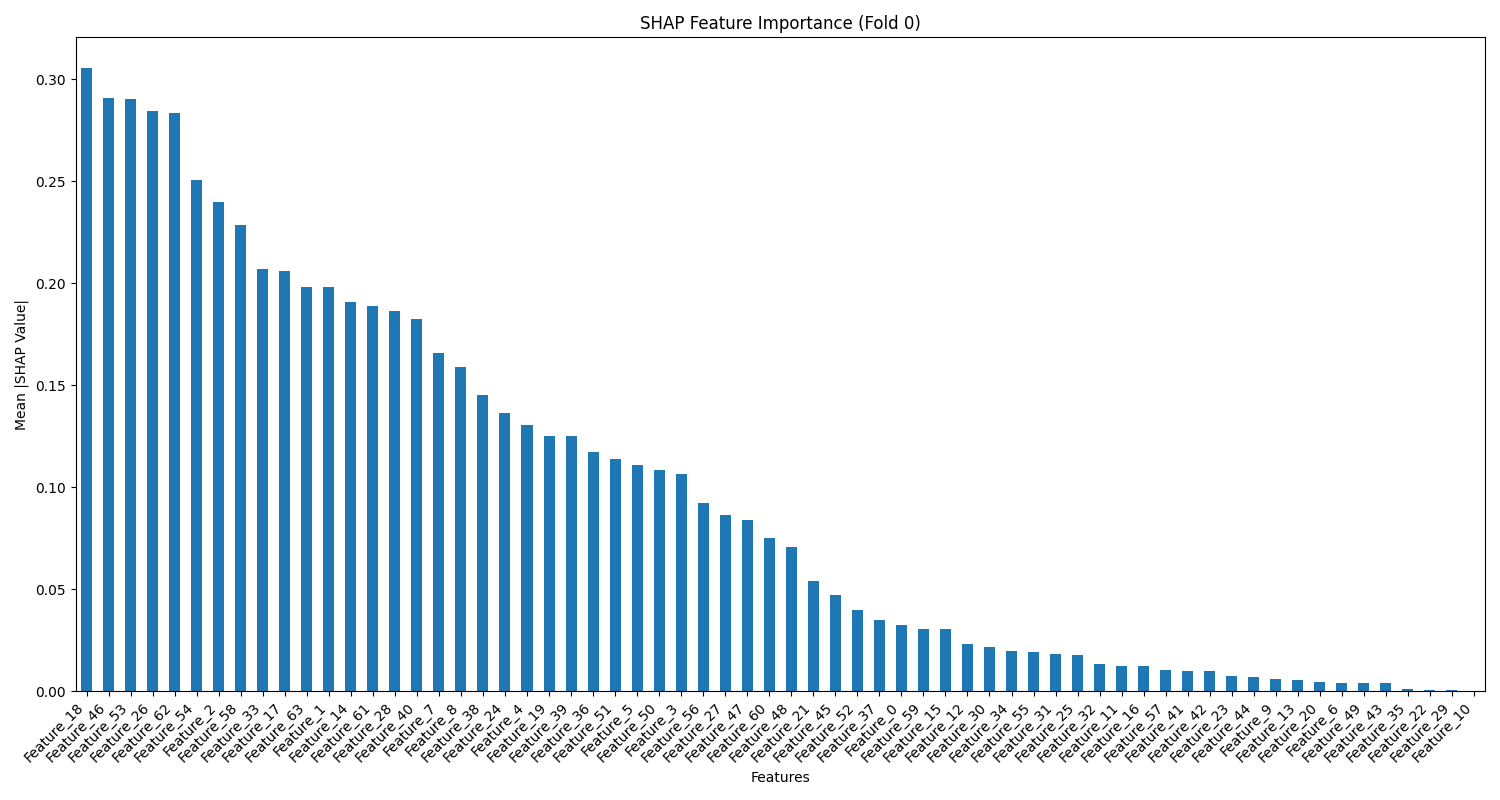

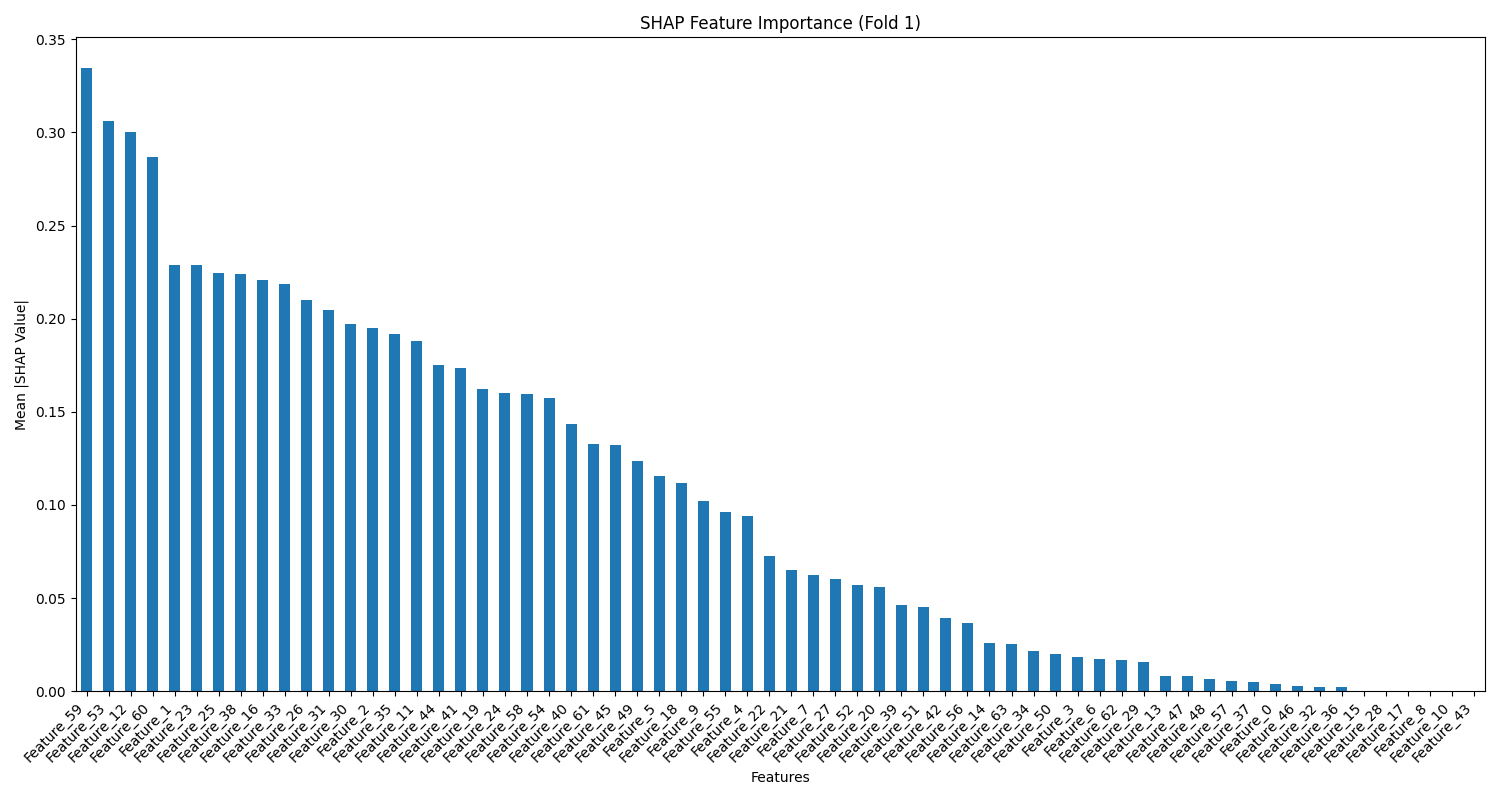

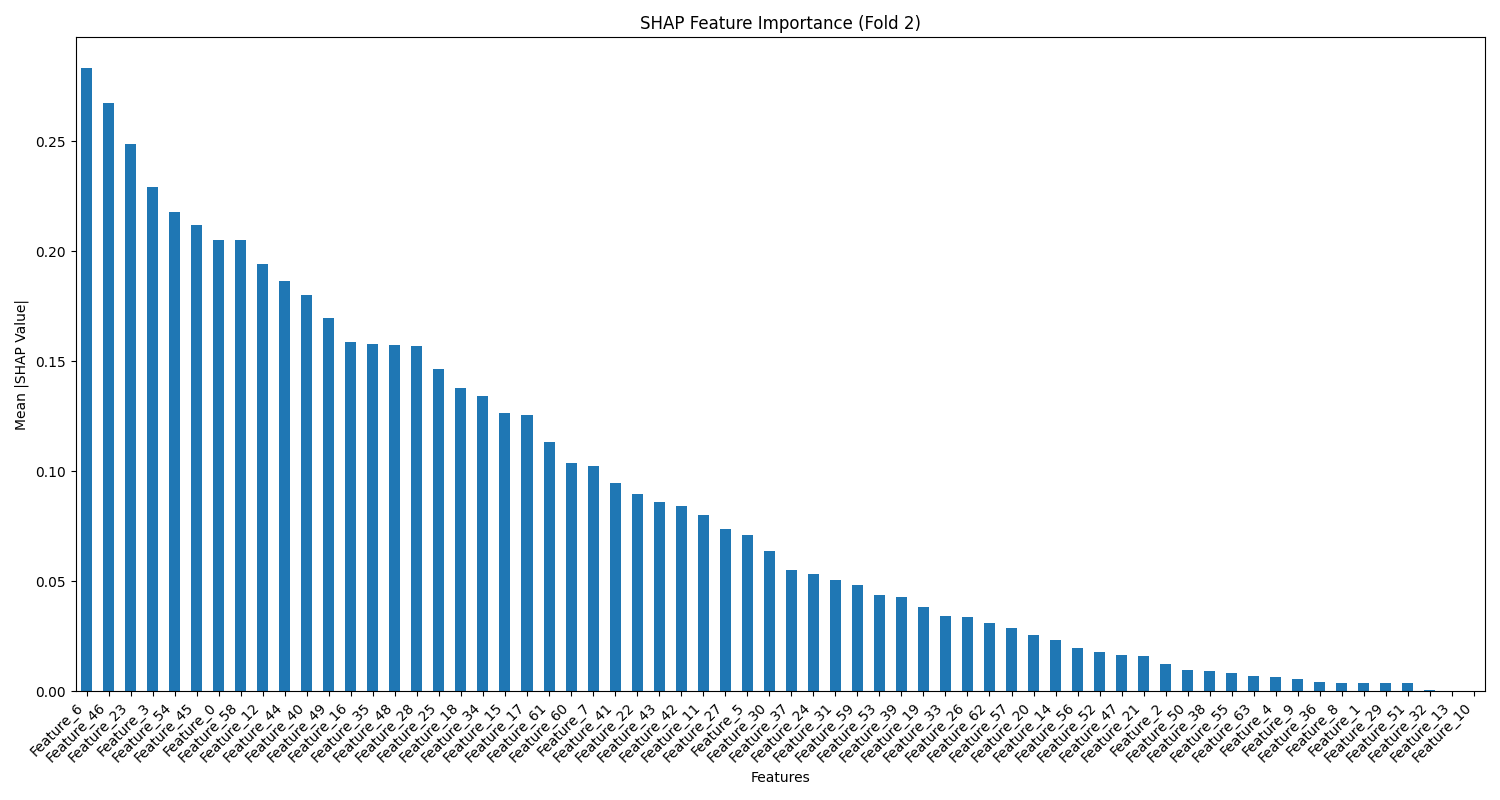

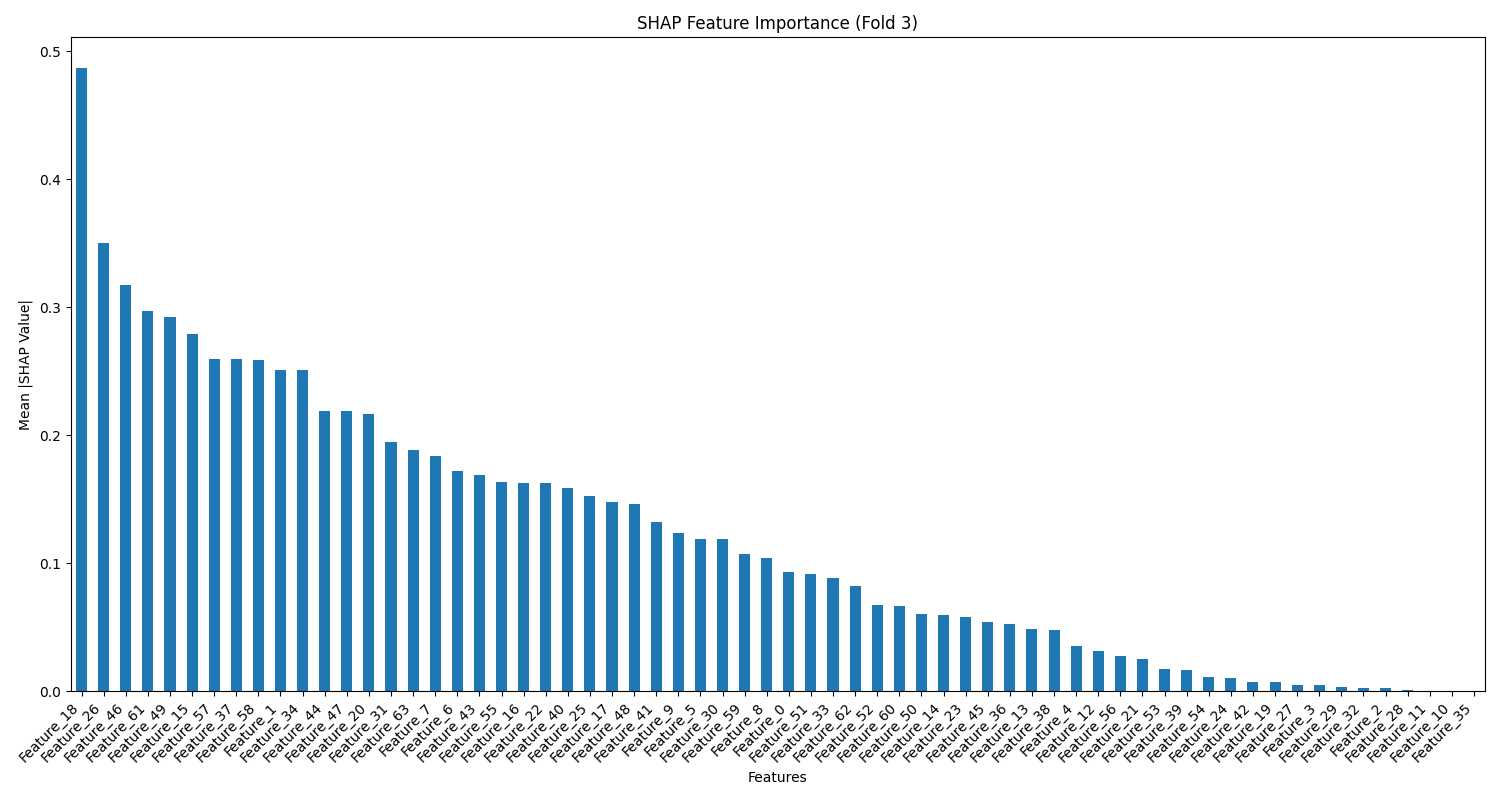

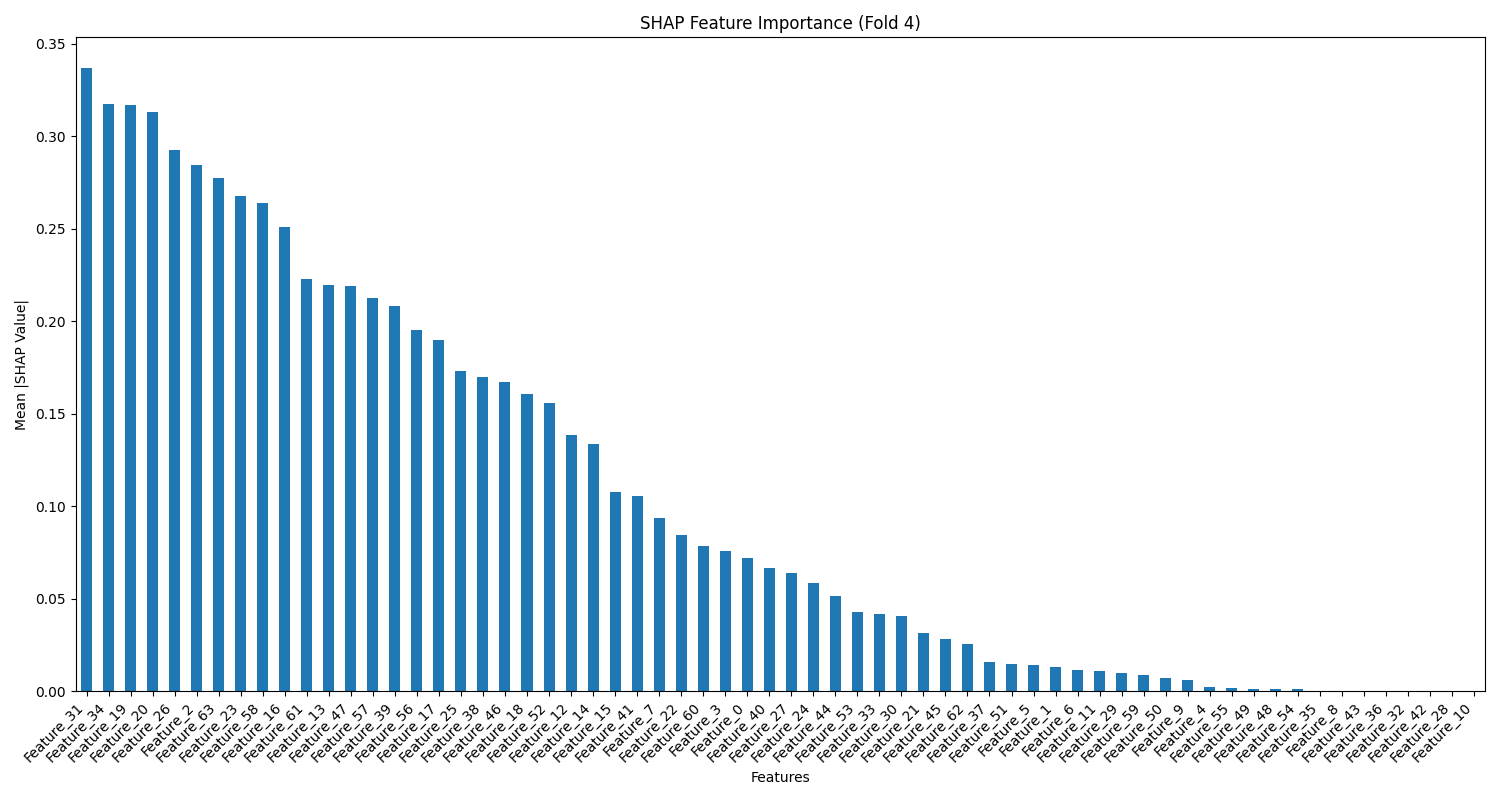

In [101]:
def plot_shap_importance(shap_importance, fold, feature_names=None):
    """
    Plot SHAP feature importance as a bar chart.

    Args:
        shap_importance (pd.Series): Mean absolute SHAP values for each feature.
        fold (int): Fold index for labeling the plot.
        feature_names (list, optional): List of feature names to include in the plot. If provided,
                                         only these features will be plotted.
    """

    if feature_names is not None:
        # Filter shap_importance for the specified features
        shap_importance = shap_importance[shap_importance.index.isin(feature_names)]

    plt.figure(figsize=(15, 8))
    shap_importance.plot(kind="bar")
    plt.title(f"SHAP Feature Importance (Fold {fold})")
    plt.xlabel("Features")
    plt.ylabel("Mean |SHAP Value|")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

for fold, shap_importance in enumerate(mean_shap_importances):
    plot_shap_importance(shap_importance, fold)


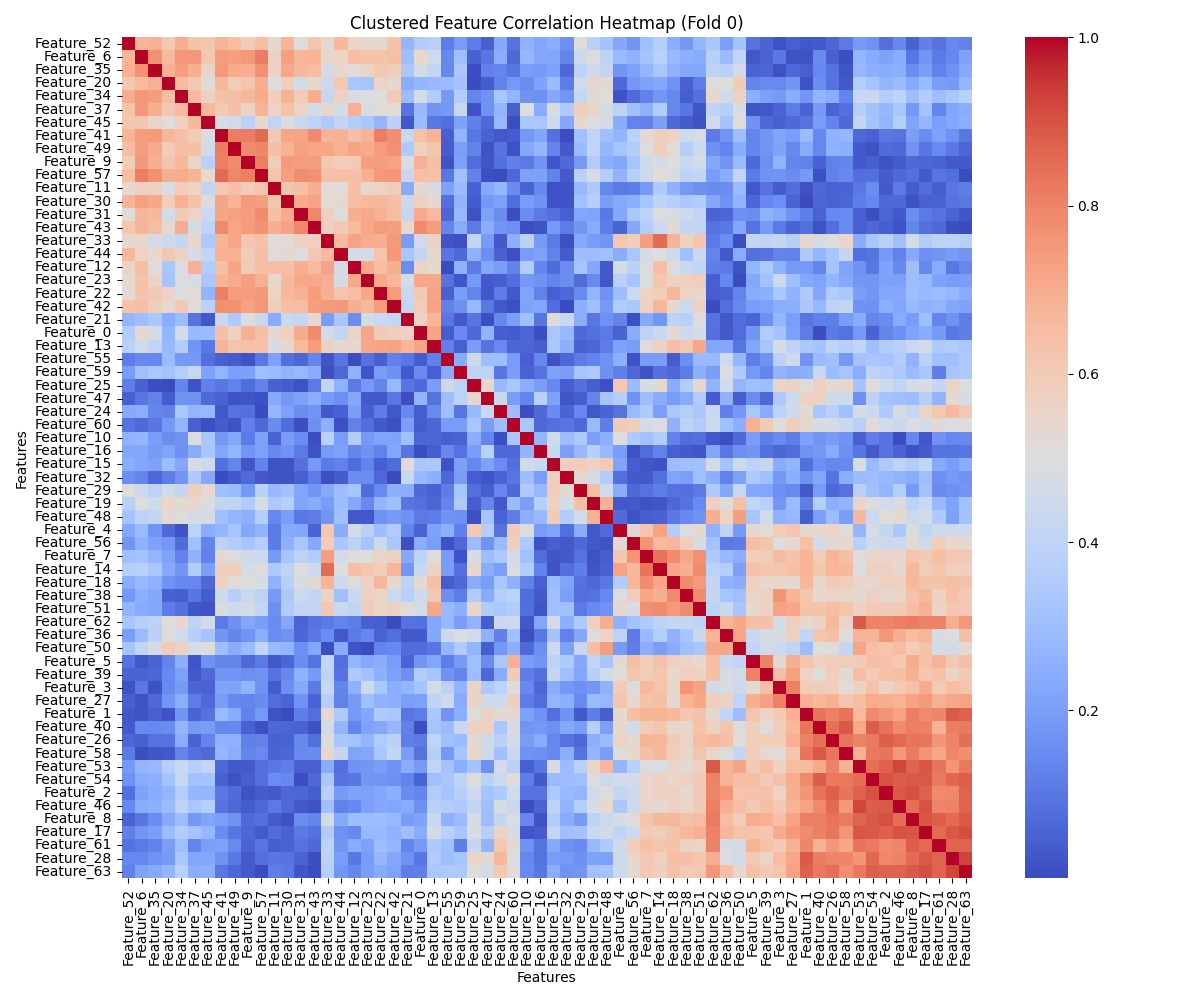

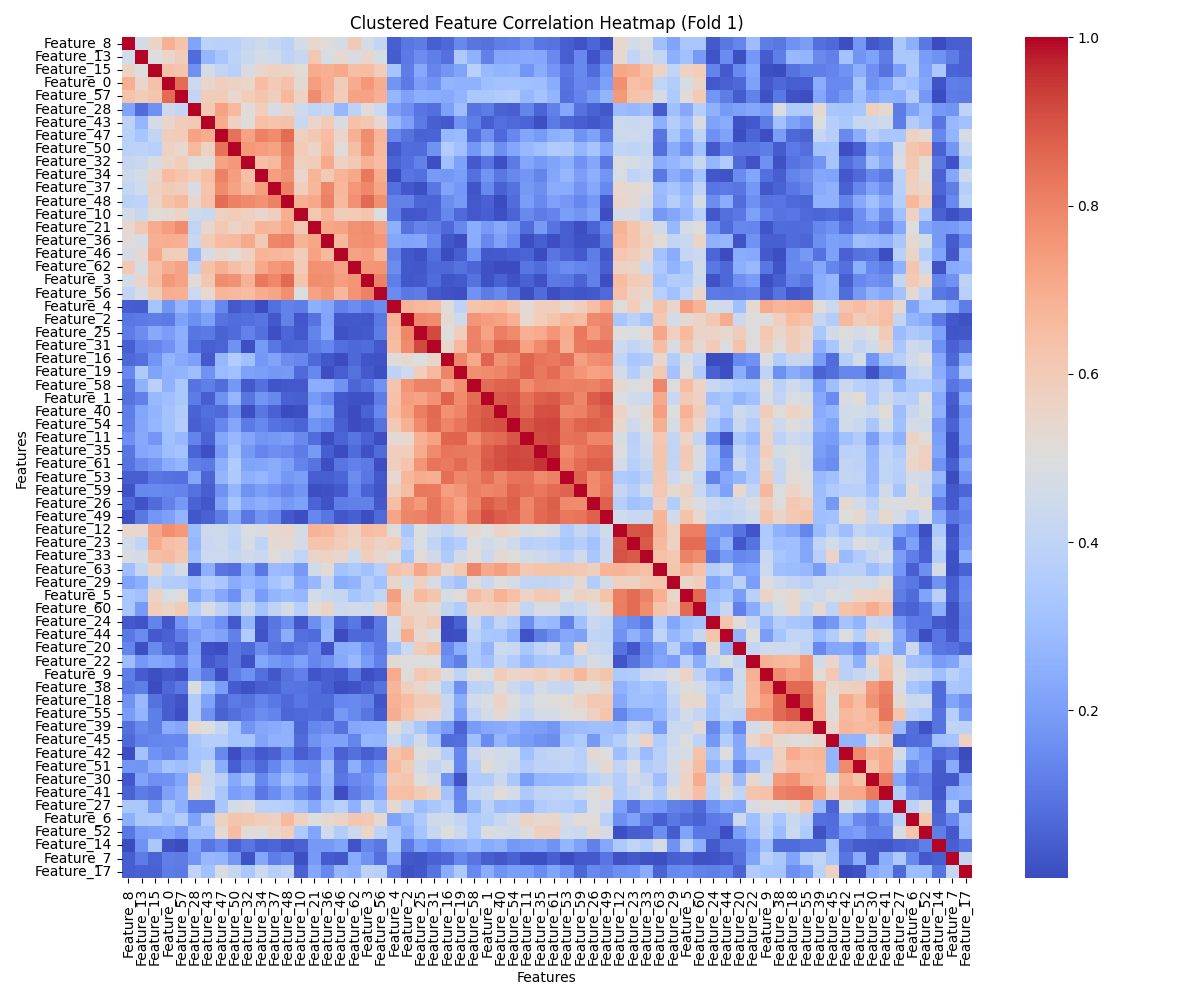

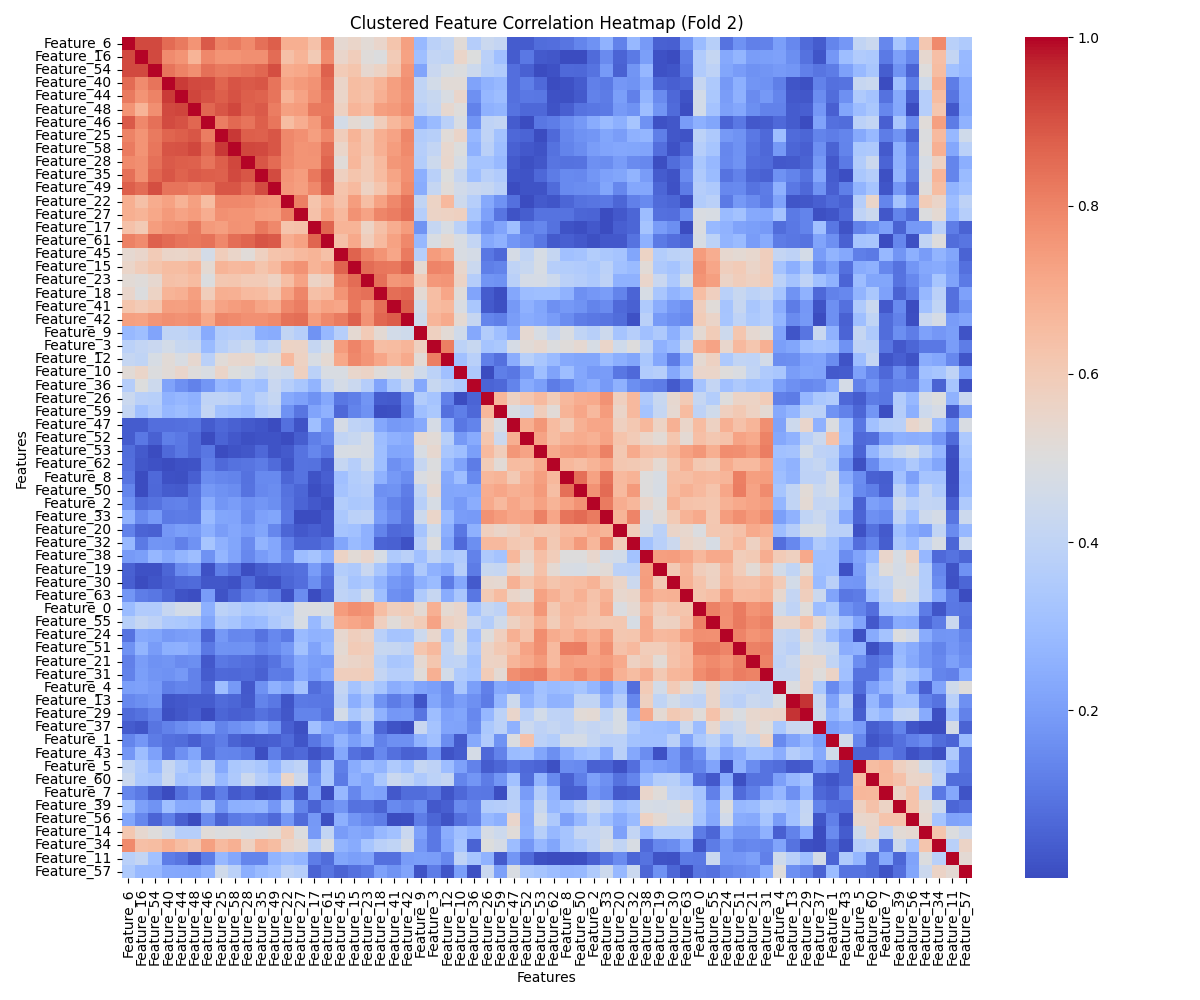

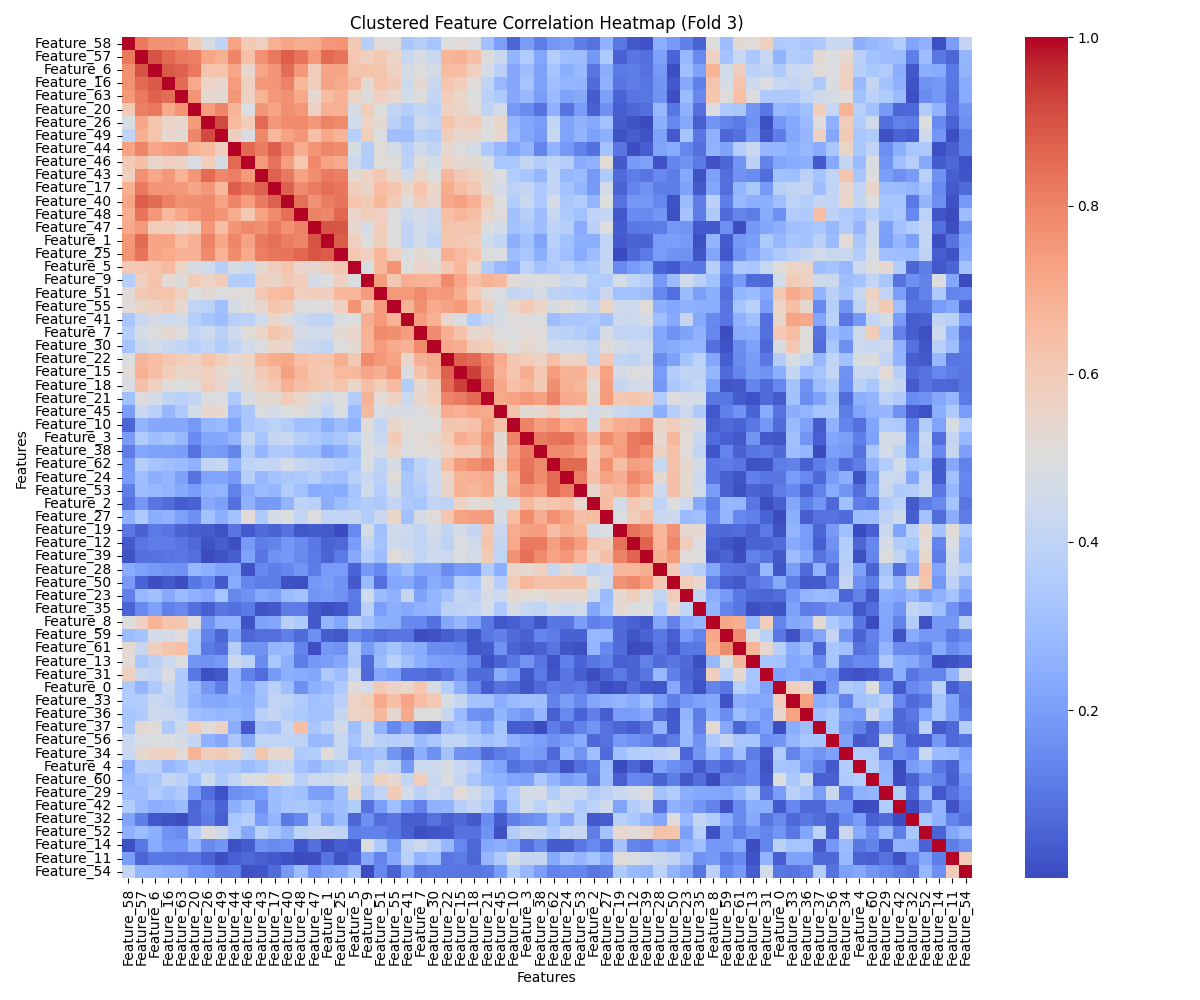

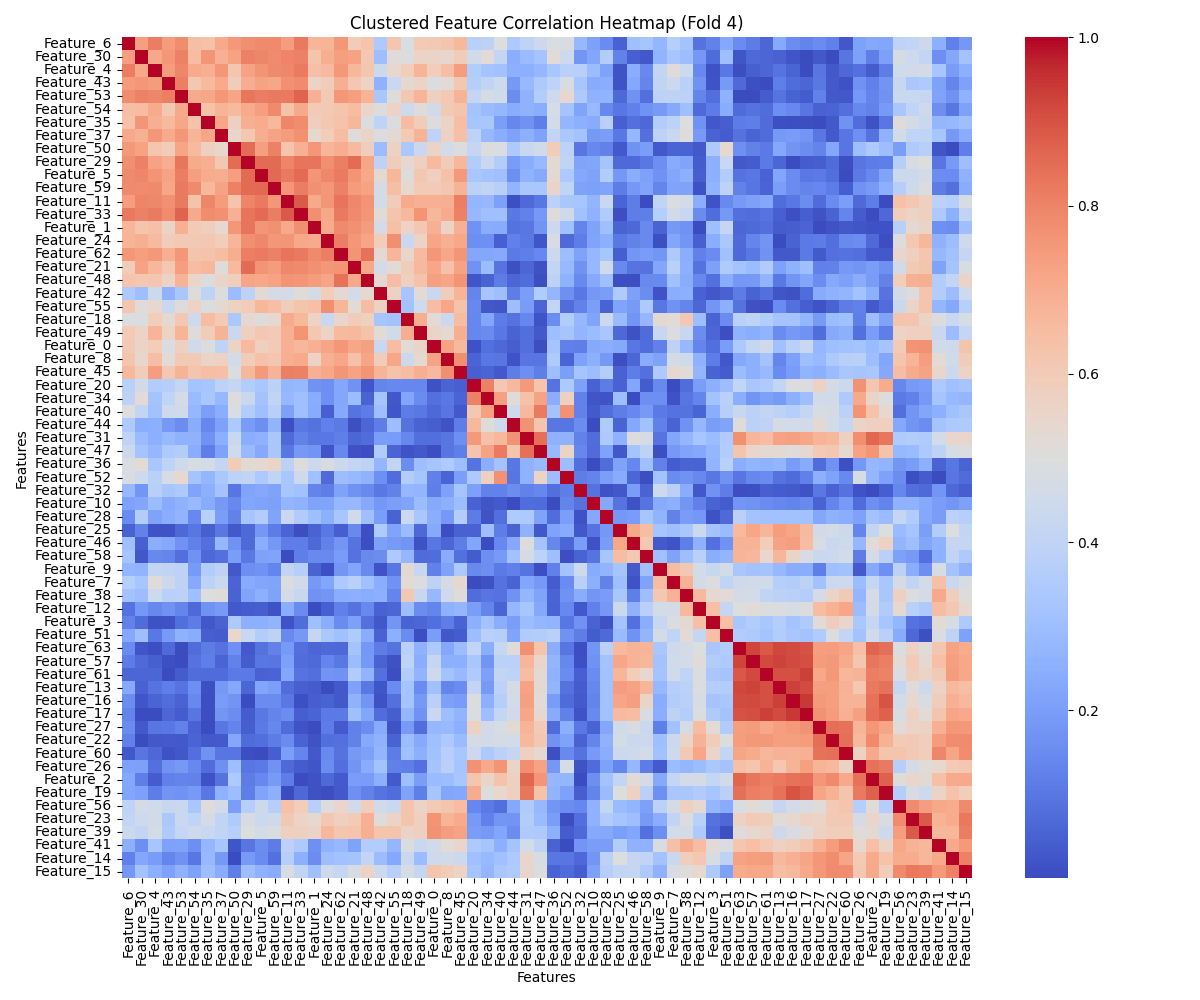

In [102]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

def plot_clustered_feature_heatmap(features, fold):
    """
    Plot a clustered heatmap of feature correlations.

    Args:
        features (numpy.ndarray): Features for a fold with shape (num_samples, num_features).
        fold (int): The fold index for labeling the plot.
    """
    # Compute feature correlation matrix
    correlation_matrix = np.corrcoef(features, rowvar=False)  # Correlation between features
    abs_correlation_matrix = np.abs(correlation_matrix)
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(abs_correlation_matrix, method='ward')
    clustered_order = leaves_list(linkage_matrix)  # Order of features after clustering

    # Reorder the correlation matrix based on clustering
    clustered_corr_matrix = abs_correlation_matrix[clustered_order][:, clustered_order]

    # Reorder feature labels
    clustered_labels = [f"Feature_{i}" for i in clustered_order]

    # Plot the clustered heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        clustered_corr_matrix,
        xticklabels=clustered_labels,
        yticklabels=clustered_labels,
        cmap="coolwarm",
        annot=False,
        fmt=".2f",
        cbar=True
    )
    plt.title(f"Clustered Feature Correlation Heatmap (Fold {fold})")
    plt.xlabel("Features")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

# Plot for each fold
for fold, features in enumerate(latent_spaces):
    plot_clustered_feature_heatmap(features, fold)

In [103]:
def feature_engineering_pipeline(mean_shap_df, latent_space, shap_threshold=0.05, corr_threshold=0.8):
    """
    Feature engineering pipeline based on SHAP values and feature correlations.

    Args:
        mean_shap_df (pd.Series): Mean absolute SHAP values indexed by feature names.
        latent_space (pd.DataFrame): Latent space values for all features (samples x features).
        shap_threshold (float): Threshold for mean absolute SHAP values.
        corr_threshold (float): Threshold for absolute correlation coefficients.

    Returns:
        pd.DataFrame: Final latent space values of retained features (samples x features).
        list: Final list of retained feature names.
    """
    # Step 1: Filter features based on SHAP threshold
    retained_features = mean_shap_df[mean_shap_df > shap_threshold].index
    retained_features = retained_features.intersection(latent_space.columns)  # Align with latent_space
    print(f"Retained {len(retained_features)} features after SHAP filtering.")

    # Step 2: Compute absolute correlation matrix for retained features
    retained_latent_space = latent_space[retained_features]  # Latent space for retained features
    correlation_matrix = retained_latent_space.corr()
    abs_correlation_matrix = np.abs(correlation_matrix)

    # Step 3: Identify clusters of correlated features
    linkage_matrix = linkage(abs_correlation_matrix, method="ward")
    clusters = fcluster(linkage_matrix, t=1 - corr_threshold, criterion="distance")
    cluster_groups = {cluster: [] for cluster in np.unique(clusters)}

    for feature, cluster in zip(abs_correlation_matrix.columns, clusters):
        cluster_groups[cluster].append(feature)

    # Step 4: Keep the most important feature from each cluster
    final_features = []
    for cluster, features in cluster_groups.items():
        if len(features) > 1:
            # Keep only the feature with the highest mean SHAP value
            most_important_feature = max(features, key=lambda f: mean_shap_df[f])
            final_features.append(most_important_feature)
        else:
            final_features.extend(features)

    # Step 5: Resolve any remaining pairs with correlation > threshold
    retained_latent_space = latent_space[final_features]
    correlation_matrix = retained_latent_space.corr()
    abs_correlation_matrix = np.abs(correlation_matrix)

    while True:
        correlated_pairs = [
            (i, j)
            for i in abs_correlation_matrix.columns
            for j in abs_correlation_matrix.columns
            if i != j and abs_correlation_matrix.loc[i, j] > corr_threshold
        ]
        if not correlated_pairs:
            break

        # Remove the less important feature from each correlated pair
        features_to_remove = set()
        for i, j in correlated_pairs:
            less_important = i if mean_shap_df[i] < mean_shap_df[j] else j
            features_to_remove.add(less_important)

        final_features = [f for f in final_features if f not in features_to_remove]
        retained_latent_space = latent_space[final_features]
        correlation_matrix = retained_latent_space.corr()
        abs_correlation_matrix = np.abs(correlation_matrix)

    print(f"Retained {len(final_features)} features after correlation filtering.")

    # Step 6: Plot final heatmap of retained features correlation
    final_corr_matrix = abs_correlation_matrix.loc[final_features, final_features]
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        final_corr_matrix,
        xticklabels=final_features,
        yticklabels=final_features,
        cmap="coolwarm",
        annot=True,
        cbar=True
    )
    plt.title("Final Retained Features Correlation Heatmap")
    plt.xlabel("Features")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

    return retained_latent_space, final_features

Retained 28 features after SHAP filtering.
Retained 7 features after correlation filtering.


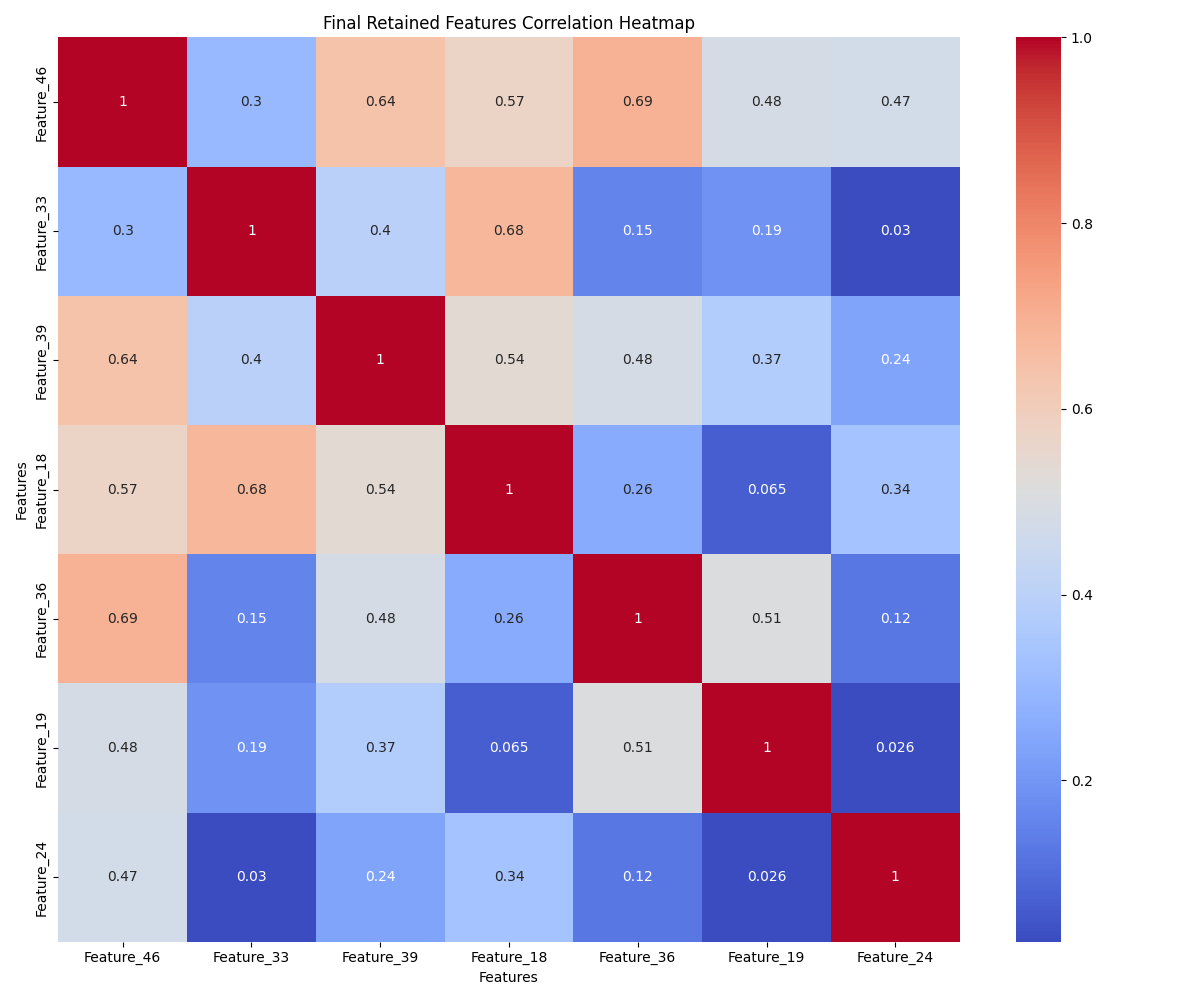

In [104]:
final_latent_space, final_features = feature_engineering_pipeline(
    mean_shap_df=mean_shap_importances[0],
    latent_space=latent_spaces_df[0],
    shap_threshold=0.1,
    corr_threshold=0.7
)

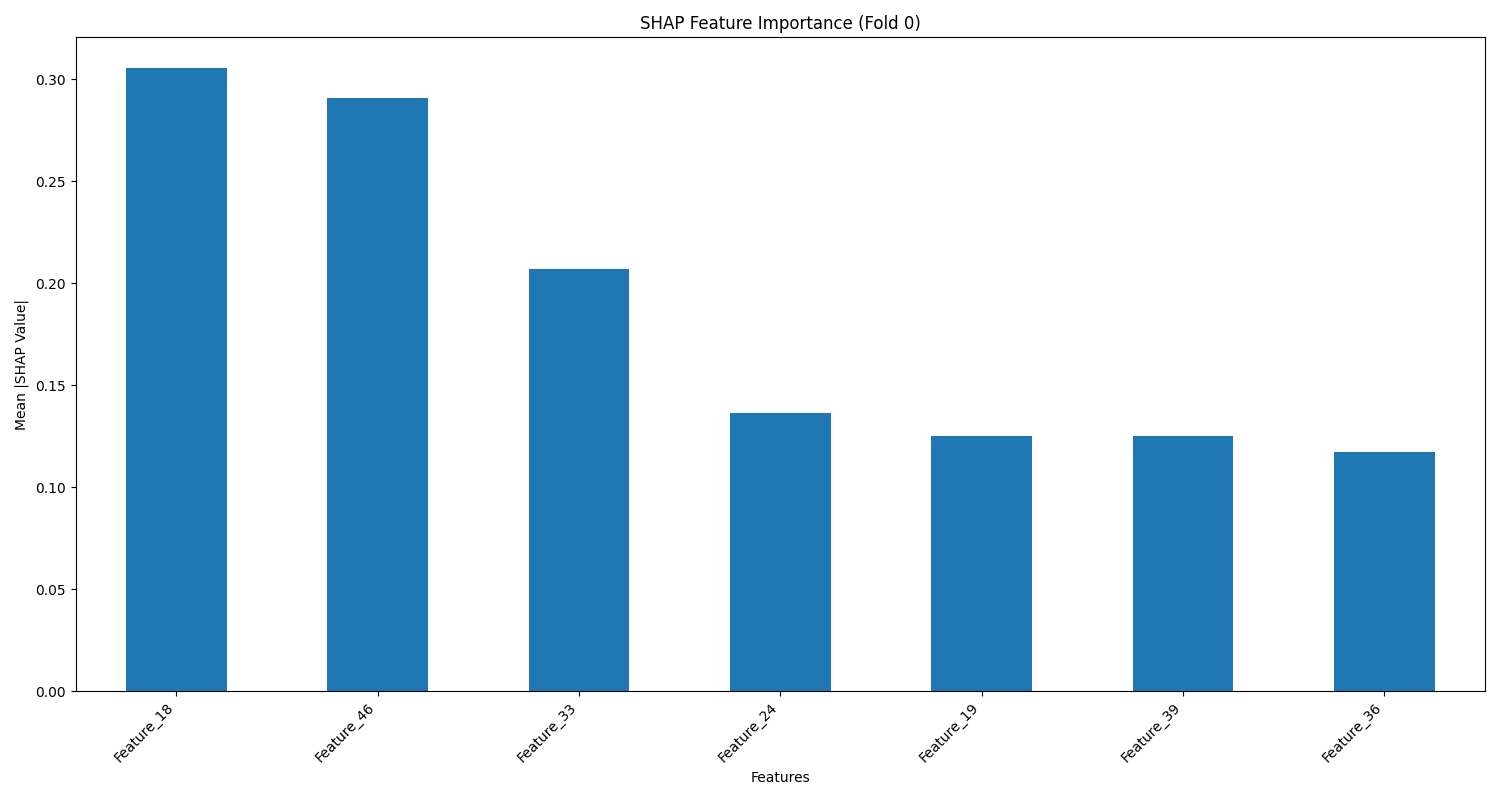

In [105]:
plot_shap_importance(mean_shap_importances[0], 0, final_features)

In [ ]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_folds_index[0])
train_loader_images = torch.utils.data.DataLoader(normalized_datasets_train_set[0], num_workers=12, batch_size=16, sampler=train_sampler)

train_latent_space = extract_latent_space_and_compute_shap_importance(
    model=models[0],
    data_loader=train_loader_images,
    device=device,
    importance=False
)

In [109]:
train_latent_space.shape

(1927, 64)

In [114]:
eval_size = len(data_without_amb_eval)
eval_data_images = DataLoader(data_without_amb_eval, num_workers=12, batch_size=eval_size, shuffle=False)
# Compute SHAP values for the penultimate layer
eval_latent_space = extract_latent_space_and_compute_shap_importance(
    model=models[0],
    data_loader=eval_data_images,
    device=device,
    importance=False
)

In [115]:
eval_latent_space.shape

(910, 64)

In [99]:
models = [model.to(device) for model in models_list]
latent_spaces = []
for fold in range(0, 5):
    train_sampler = torch.utils.data.SubsetRandomSampler(train_folds_index[fold])
    train_loader_images = torch.utils.data.DataLoader(normalized_datasets_train[fold], num_workers=12, batch_size=16, sampler=train_sampler, collate_fn=collate_only_images)
    eval_size = len(data_without_amb_eval)
    eval_data_images = DataLoader(data_without_amb_eval, num_workers=12, batch_size=eval_size, shuffle=False, collate_fn=collate_only_images)
    for eval_batch in eval_data_images:
        latent_space = extract_latent_space(models[fold], eval_batch, device, train_loader_images)
    latent_spaces.append(latent_space)

In [ ]:
import umap

In [ ]:
# Prepare lists to store PCA and UMAP-reduced data
pca_train_data = []
pca_test_data = []
umap_train_data = []
umap_test_data = []

for fold in range(0, 5):
    # Extract train and test data
    train_np = latent_spaces[fold]['train'].numpy()
    test_np = latent_spaces[fold]['test'].numpy()

    # PCA on training data only
    pca = PCA(n_components=9)
    train_pca = pca.fit_transform(train_np)
    test_pca = pca.transform(test_np)  # Transform test data using trained PCA

    pca_train_data.append(train_pca)
    pca_test_data.append(test_pca)

    # UMAP on PCA-reduced training data
    reducer = umap.UMAP(n_components=2, random_state=42)
    train_umap = reducer.fit_transform(train_pca)
    test_umap = reducer.transform(test_pca)  # Transform test data using trained UMAP

    umap_train_data.append(train_umap)
    umap_test_data.append(test_umap)

In [128]:
def visualize_umap_with_labels(umap_train, umap_test, success_indices, failure_indices, fold=0):
    """
    Visualizes UMAP-reduced train and test data with success/failure labels.

    Args:
        umap_train (list): List of UMAP-reduced train data arrays for all folds.
        umap_test (list): List of UMAP-reduced test data arrays for all folds.
        success_indices (list): List of indices for success cases in the test set.
        failure_indices (list): List of indices for failure cases in the test set.
        fold (int): Fold index to visualize.
    """
    train_data = umap_train[fold]
    test_data = umap_test[fold]

    plt.figure(figsize=(10, 7))

    # Plot train data (no labels)
    plt.scatter(train_data[:, 0], train_data[:, 1], label='Train', alpha=0.6, color='blue')

    # Plot success cases in test data
    plt.scatter(
        test_data[success_indices, 0],
        test_data[success_indices, 1],
        label='Success (Test)',
        alpha=0.8,
        color='green',
        marker='x'
    )

    # Plot failure cases in test data
    plt.scatter(
        test_data[failure_indices, 0],
        test_data[failure_indices, 1],
        label='Failure (Test)',
        alpha=0.8,
        color='red',
        marker='x'
    )

    # Add plot details
    plt.title(f"UMAP Visualization of Latent Space (Fold {fold})")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Visualize UMAP for fold 0
visualize_umap_with_labels(umap_train_data, umap_test_data, good_idx, bad_idx, fold=3)

In [136]:
def mahalanobis_distance(train_data, test_data):
    """
    Compute Mahalanobis distance between test samples and the training distribution.

    Args:
        train_data (torch.Tensor): Training data in reduced space, shape (N_train, features).
        test_data (torch.Tensor): Test data in reduced space, shape (N_test, features).

    Returns:
        torch.Tensor: Mahalanobis distances for test samples, shape (N_test,).
    """

    # Compute mean and covariance of the training data
    mean = np.mean(train_data, axis=0)
    cov = np.cov(train_data, rowvar=False)
    cov_inv = np.linalg.inv(cov)

    # Compute Mahalanobis distance for each test sample
    distances = []
    for x in test_data:
        diff = x - mean
        distance = np.sqrt(diff.T @ cov_inv @ diff)
        distances.append(distance)
    
    return distances

In [137]:
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import NearestNeighbors

In [138]:
def kde_density(train_data, test_data):
    """
    Estimate the density of test samples based on the training distribution using KDE.

    Args:
        train_data (torch.Tensor): Training data in reduced space, shape (N_train, features).
        test_data (torch.Tensor): Test data in reduced space, shape (N_test, features).

    Returns:
        torch.Tensor: Negative log-density scores for test samples, shape (N_test,).
    """
    # Fit KDE on training data
    kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(train_data)

    # Evaluate log-density for test data
    log_density = kde.score_samples(test_data)

    # Return negative log-density as OOD metric
    return -log_density

In [139]:
def knn_distance(train_data, test_data, k=5):
    """
    Compute K-Nearest Neighbors (KNN) distance for OOD detection.

    Args:
        train_data (torch.Tensor): Training data in reduced space, shape (N_train, features).
        test_data (torch.Tensor): Test data in reduced space, shape (N_test, features).
        k (int): Number of neighbors to consider.

    Returns:
        torch.Tensor: KNN distances for test samples, shape (N_test,).
    """

    # Fit KNN on training data
    knn = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(train_data)

    # Find the k-nearest neighbors for test samples
    distances, _ = knn.kneighbors(test_data)

    # Aggregate distances (e.g., mean distance to k neighbors)
    knn_distances = np.mean(distances, axis=1)

    # Convert back to tensor
    return knn_distances

In [152]:
kde_density_data = []
mahalanobis_distance_data = []
knn_distances_data = []
for fold in range(0, 5):
    scores = kde_density(pca_train_data[fold], pca_test_data[fold])
    distances = mahalanobis_distance(pca_train_data[fold], pca_test_data[fold])
    knn_distances = knn_distance(pca_train_data[fold], pca_test_data[fold])
    kde_density_data.append(scores)
    mahalanobis_distance_data.append(distances)
    knn_distances_data.append(knn_distances)

In [ ]:
plt.close('all')
for fold in range(0, 5):
    sns.pairplot(pd.DataFrame(np.array([mahalanobis_distance_data[fold], knn_distances_data[fold], kde_density_data[fold]]).T))
    plt.show()

In [155]:
mean_knn_distances = np.mean(np.stack(knn_distances_data), axis=0)
mean_mahalanobis_distances = np.mean(np.stack(mahalanobis_distance_data), axis=0)
mean_kde_density = np.mean(np.stack(kde_density_data), axis=0)

In [ ]:
plt.close('all')
uq.UQ_method_plot([mean_mahalanobis_distances[k] for k in good_idx], [mean_mahalanobis_distances[j] for j in bad_idx], 'KDE_densities', 'KDE Densities Test set vs Train set in latent space')

In [28]:
#results, name = uq.apply_randaugment_and_store_results(calibration_data_gps, models, 2, 45, 2000, device, binary_classification=True, batch_norm=False, mean=mean, std=std)

In [ ]:
auc = []
auc_robust = []
for _ in range(20):
    print(_)
    best_aug, best_aug_robust = uq.perform_greedy_policy_search('savedpolicies_testset', good_idx, bad_idx, num_workers=90, max_iterations=30, num_searches=30, top_k=5, plot=False)
    n, m, transformations = uq.extract_gps_augmentations_info(best_aug)
    stds_GPS, global_preds_GPS = uq.TTA(transformations, models, calibration_data_gps, device, usingBetterRandAugment=True, n=n, m=m, bw=True, mean=mean, std=std)
    fpr_std_gps, tpr_std_gps, auc_std_gps = uq.roc_curve_UQ_method_computation([stds_GPS[k] for k in good_idx_calibration], [stds_GPS[j] for j in bad_idx_calibration])
    
    stds_GPS_robust, global_preds_GPS_robust = uq.TTA(best_aug_robust, models, calibration_data_gps, device, usingBetterRandAugment=True, n=n, m=m, bw=True, mean=mean, std=std)
    fpr_std_gps_robust, tpr_std_gps_robust, auc_std_gps_robust = uq.roc_curve_UQ_method_computation([stds_GPS_robust[k] for k in good_idx_calibration], [stds_GPS_robust[j] for j in bad_idx_calibration])
    auc.append(auc_std_gps)
    auc_robust.append(auc_std_gps_robust)

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot([auc, auc_robust], labels=["GPS", "Robust_GPS"], patch_artist=True)
plt.title("20 GPS runs: best vs most selected augmentations")
plt.ylabel("AUC")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Displaying the plot
plt.show()

In [ ]:
best_aug_robust

In [ ]:
n, m, transformations = uq.extract_gps_augmentations_info(best_aug)
stds_GPS, global_preds_GPS = uq.TTA(transformations, models, eval_data_gps, device, usingBetterRandAugment=True, n=n, m=m, bw=True, mean=mean, std=std)
fpr_std_gps, tpr_std_gps, auc_std_gps = uq.roc_curve_UQ_method_computation([stds_GPS[k] for k in good_idx], [stds_GPS[j] for j in bad_idx])

In [ ]:
stds_GPS_robust, global_preds_GPS_robust = uq.TTA(best_aug_robust, models, eval_data_gps, device, usingBetterRandAugment=True, n=n, m=m, bw=True, mean=mean, std=std)
fpr_std_gps_robust, tpr_std_gps_robust, auc_std_gps_robust = uq.roc_curve_UQ_method_computation([stds_GPS_robust[k] for k in good_idx], [stds_GPS_robust[j] for j in bad_idx])

In [ ]:
uq.UQ_method_plot([stds_GPS[k] for k in good_idx], [stds_GPS[j] for j in bad_idx], 'Stds', 'GPS')

In [ ]:
uq.UQ_method_plot([stds_GPS_robust[k] for k in good_idx], [stds_GPS_robust[j] for j in bad_idx], 'Stds', 'GPS')

In [ ]:
auc_std_gps_robust

In [ ]:
auc_std_gps

In [ ]:
uq.model_calibration_plot(np.array(true_labels_calibration), np.array(mean_pred_calibration))

In [35]:
stds = uq.ensembling_stds_computation(models_pred)
distances = uq.distance_to_hard_labels_computation(mean_ensembling_pred)

In [36]:
stds_calibration = uq.ensembling_stds_computation(models_pred_calibration)
distances_calibration = uq.distance_to_hard_labels_computation(mean_ensembling_pred_calibration)

In [ ]:
uq.UQ_method_plot([stds[k] for k in good_idx], [stds[j] for j in bad_idx], 'Stds', 'Standard deviations ensembling')

In [ ]:
uq.UQ_method_plot([stds_calibration[k] for k in good_idx_calibration], [stds_calibration[j] for j in bad_idx_calibration], 'Stds', 'Standard deviations ensembling')

In [ ]:
uq.UQ_method_plot([distances_calibration[k] for k in good_idx_calibration], [distances_calibration[j] for j in bad_idx_calibration], 'min(prob; 1-prob)', 'Distance to hard labels')

In [45]:
data_without_amb_TTA = axialcuts_dataset_eval.data[axialcuts_dataset_eval.data['Shape']!='Ambiguous']
data_without_amb_TTA = AxialCutsDataset(data_shape=data_without_amb_TTA, downsample=False)
eval_data_TTA = DataLoader(data_without_amb_TTA, batch_size=128, num_workers=12, shuffle=False)

In [46]:
tta_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.RandAugment(2, 9),
                    transforms.PILToTensor(),
                    transforms.Lambda(lambda x: x.float()), 
                    transforms.Normalize(mean=mean, std=std)
                ])

In [47]:
crops_flips_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(size=49, scale=(0.8, 1.0)),  # Random crop with resizing
    transforms.RandomHorizontalFlip(p=0.5),                   # Random horizontal flip
    transforms.RandomRotation(degrees=180),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.float()), 
    transforms.Normalize(mean=mean, std=std)# Random rotation within ±30 degrees
])

In [48]:
stds_crops, global_preds_crops = uq.TTA(crops_flips_transforms, models, eval_data_TTA, device, 5)

In [49]:
stds_tta, global_preds_tta = uq.TTA(tta_transform, models, eval_data_TTA, device, 5)

In [ ]:
uq.UQ_method_plot([stds_crops[k] for k in good_idx], [stds_crops[j] for j in bad_idx], 'Stds', 'Test Time Crops, Flips, Rotations (n=5)')

In [ ]:
uq.UQ_method_plot([stds_tta[k] for k in good_idx], [stds_tta[j] for j in bad_idx], 'Stds', 'Test Time Augmentation (n=5)')

In [ ]:
uq.UQ_method_plot([stds_GPS[k] for k in good_idx], [stds_GPS[j] for j in bad_idx], 'Stds', 'GPS')

In [40]:
mean_values = uq.standardize_and_mean_ensembling(np.column_stack((stds_GPS, stds, distances)))

In [51]:
distributions = np.column_stack((stds_GPS, stds, distances))
# Flatten the array to compute the global mean and standard deviation
combined = distributions.flatten()

# Compute global mean and standard deviation
global_mean = np.mean(combined)
global_std_dev = np.std(combined)

# Apply z-score standardization to each distribution (column)
standardized_distributions = (distributions - global_mean) / global_std_dev

# Find the maximum standardized value for each instance (row)
median_values = np.median(standardized_distributions, axis=1)

In [ ]:
standardized_distributions

In [59]:
# Extract failure cases
failure_data = standardized_distributions[bad_idx]

# Calculate 25th and 75th percentiles for each feature
percentiles_25 = np.percentile(standardized_distributions, 25, axis=0)
percentiles_75 = np.percentile(standardized_distributions, 75, axis=0)

# Identify cases missed by all 3 features (below 25th percentile for all features)
missed_cases = np.all(failure_data < percentiles_25, axis=1)

# Identify cases identified by all 3 features (above 75th percentile for all features)
identified_cases = np.all(failure_data > percentiles_75, axis=1)

# Count the number of missed and identified failure cases
num_missed_cases = np.sum(missed_cases)
num_identified_cases = np.sum(identified_cases)


In [ ]:
percentiles_25

In [ ]:
num_identified_cases

In [ ]:
uq.UQ_method_plot([mean_values[k] for k in good_idx], [mean_values[j] for j in bad_idx], 'Combined metric', 'Combined UQ methods')

In [ ]:
fpr_std_tta, tpr_std_tta, auc_std_tta = uq.roc_curve_UQ_method_computation([stds_tta[k] for k in good_idx], [stds_tta[j] for j in bad_idx])
fpr_std_crops, tpr_std_crops, auc_std_crops =  uq.roc_curve_UQ_method_computation([stds_crops[k] for k in good_idx], [stds_crops[j] for j in bad_idx])
fpr_std_gps, tpr_std_gps, auc_std_gps = uq.roc_curve_UQ_method_computation([stds_GPS[k] for k in good_idx], [stds_GPS[j] for j in bad_idx])
uq.roc_curve_UQ_methods_plot(['Standard deviation random crops/flips/rotation', 'Standard deviation TTA', 'Standard deviation GPS'], [fpr_std_crops, fpr_std_tta, fpr_std_gps], [tpr_std_crops, tpr_std_tta, tpr_std_gps], [auc_std_crops, auc_std_tta, auc_std_gps])

In [ ]:
fpr_distance_to_gstd, tpr_distance_to_gstd, auc_distance_to_gstd = uq.roc_curve_UQ_method_computation([distances[k] for k in good_idx], [distances[j] for j in bad_idx])
fpr_std, tpr_std, auc_std = uq.roc_curve_UQ_method_computation([stds[k] for k in good_idx], [stds[j] for j in bad_idx])
#fpr_std_tta, tpr_std_tta, auc_std_tta = uq.roc_curve_UQ_method_computation([stds_tta[k] for k in good_idx], [stds_tta[j] for j in bad_idx])
#fpr_std_gps, tpr_std_gps, auc_std_gps = uq.roc_curve_UQ_method_computation([stds_GPS[k] for k in good_idx], [stds_GPS[j] for j in bad_idx])
fpr_combined, tpr_combined, auc_combined = uq.roc_curve_UQ_method_computation([mean_values[k] for k in good_idx], [mean_values[j] for j in bad_idx])

uq.roc_curve_UQ_methods_plot(['Distance to hard labels', 'Standard deviation models ensembling', 'Standard deviation GPS', 'Combined'], [fpr_distance_to_gstd, fpr_std, fpr_std_gps, fpr_combined], [tpr_distance_to_gstd, tpr_std, tpr_std_gps, tpr_combined], [auc_distance_to_gstd, auc_std, auc_std_gps, auc_combined])

In [ ]:
fpr_distance_to_gstd, tpr_distance_to_gstd, auc_distance_to_gstd = uq.roc_curve_UQ_method_computation([distances[k] for k in good_idx], [distances[j] for j in bad_idx])
fpr_std, tpr_std, auc_std = uq.roc_curve_UQ_method_computation([stds[k] for k in good_idx], [stds[j] for j in bad_idx])
#fpr_std_tta, tpr_std_tta, auc_std_tta = uq.roc_curve_UQ_method_computation([stds_tta[k] for k in good_idx], [stds_tta[j] for j in bad_idx])
#fpr_std_gps, tpr_std_gps, auc_std_gps = uq.roc_curve_UQ_method_computation([stds_GPS[k] for k in good_idx], [stds_GPS[j] for j in bad_idx])
fpr_combined, tpr_combined, auc_combined = uq.roc_curve_UQ_method_computation([median_values[k] for k in good_idx], [median_values[j] for j in bad_idx])

uq.roc_curve_UQ_methods_plot(['Distance to hard labels', 'Standard deviation models ensembling', 'Standard deviation GPS', 'Combined'], [fpr_distance_to_gstd, fpr_std, fpr_std_gps, fpr_combined], [tpr_distance_to_gstd, tpr_std, tpr_std_gps, tpr_combined], [auc_distance_to_gstd, auc_std, auc_std_gps, auc_combined])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

total_indices = list(range(len(mean_values)))  # Assuming indices are sequential: [0, 1, 2, 3, 4]

# Create success/failure list
success_failure = [1 if i in good_idx else 0 for i in total_indices]
# Reshape for scikit-learn (LogisticRegression expects 2D input for features)
X = mean_values.reshape(-1, 1)  # Feature (uncertainty quantification values)
y = success_failure           # Target (success/failure)

# Fit logistic regression
model = LogisticRegression(class_weight='balanced', max_iter=500)
model.fit(X, y)

# Predictions and evaluation
y_pred = model.predict(X)
y_proba = model.predict_proba(X)[:, 1]  # Probabilities for the positive class

accuracy = accuracy_score(y, y_pred)
auc = roc_auc_score(y, y_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {auc:.2f}")

# Plot logistic regression fit
x_range = np.linspace(min(mean_values), max(mean_values), 100).reshape(-1, 1)
y_prob = model.predict_proba(x_range)[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(mean_values, success_failure, alpha=0.7, label="Data", edgecolor="k")
plt.plot(x_range, y_prob, color="red", label="Logistic Regression Fit")
plt.title("Logistic Regression on Uncertainty Quantification", fontsize=14)
plt.xlabel("Uncertainty Quantification", fontsize=12)
plt.ylabel("Probability of Failure", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [53]:
comb_data = np.column_stack((stds_GPS, stds, distances))
combined = comb_data.flatten()
    
# Compute global mean and standard deviation
global_mean = np.mean(combined)
global_std_dev = np.std(combined)

# Apply z-score standardization to each distribution (column)
standardized_distributions = (comb_data - global_mean) / global_std_dev

In [ ]:
def plot_lines_through_points(success, failures, title, xlabel, ylabel, methods):
    """
    Plots lines through points for each row in a 2D numpy array.
    
    Parameters:
    - data_array (numpy.ndarray): 2D array of shape (n_lines, n_points), where each row will be a line plot.
    - x_values (list or array-like, optional): X-values for the points; if None, defaults to sequential integers.
    - title (str): Title of the plot.
    - xlabel (str): Label for the X-axis.
    - ylabel (str): Label for the Y-axis.
    """
    
    cmap_success = cm.Greens
    cmap_failure = cm.Reds
    
    plt.close('all')
    n_lines_success = len(success)
    n_lines_failures = len(failures)

    x_values = range(success[0].shape[0])  # Default x-axis values if not provided
    
    plt.figure(figsize=(10, 6))
    for i in range(n_lines_success):
        plt.plot(x_values, success[i][:], color='g', alpha=0.2)
        
    for j in range(n_lines_failures):
        plt.plot(x_values, failures[j][:], color='r', alpha=0.2)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(3), methods)
    plt.grid(True)
    plt.show()

In [ ]:
plot_lines_through_points([standardized_distributions[k] for k in good_idx], [standardized_distributions[j] for j in bad_idx], 'UQ methods agreement', 'UQ Methods', 'Uncertainty score', ['Std GPS', 'Std ensembling', 'Distance to hard labels'])

In [ ]:
# Step 1: Create a DataFrame from your numpy array
df = pd.DataFrame(standardized_distributions, columns=["Std GPS", "Std Ensembling", "Distance to Hard Labels"])

# Step 2: Add a "Category" column to label each row as "Success" or "Failure"
df['Category'] = 'Success'
df.loc[bad_idx, 'Category'] = 'Failure'

# Step 3: Create a pairplot
sns.pairplot(df, hue="Category", palette={"Success": "green", "Failure": "red"}, diag_kind="kde", markers=["o", "s"])

# Show the plot
plt.suptitle("Pairplot of UQ Methods with Success/Failure Categories", y=1.02)
plt.show()

In [ ]:
plt.close('all')
# Step 3: Calculate correlations for Success and Failure cases separately
success_corr = df[df['Category'] == 'Success'].iloc[:, :-1].corr()
failure_corr = df[df['Category'] == 'Failure'].iloc[:, :-1].corr()

# Step 4: Plot the heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 7), sharey=True)

# Heatmap for Success cases
sns.heatmap(success_corr, annot=True, cmap=cm.Greens, center=0, ax=axes[0], annot_kws={"fontsize":18})
axes[0].set_title("Correlation Heatmap for Success Cases")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30)

# Heatmap for Failure cases
sns.heatmap(failure_corr, annot=True, cmap="coolwarm", center=0, ax=axes[1], annot_kws={"fontsize":18})
axes[1].set_title("Correlation Heatmap for Failure Cases")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30)

# Adjust layout

plt.tight_layout()
plt.show()

In [69]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(standardized_distributions)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
pca_result

In [ ]:
plt.close('all')
plt.scatter(pca_result[good_idx, 0], pca_result[good_idx, 1], color='g', alpha=0.5)
plt.scatter(pca_result[bad_idx, 0], pca_result[bad_idx, 1], color='r', alpha=0.5)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(standardized_distributions[good_idx, 0], standardized_distributions[good_idx, 1], standardized_distributions[good_idx, 2],  color='g', alpha=0.5)
ax.scatter(standardized_distributions[bad_idx, 0], standardized_distributions[bad_idx, 1], standardized_distributions[bad_idx, 2],  color='r', alpha=0.5)
ax.set_xlabel("Std GPS")
ax.set_ylabel("Std Ensembling")
ax.set_zlabel("Distance to Hard Labels")

In [ ]:
path_to_csv = r'/mnt/data/psteinmetz/neotex/CSV/BOUNDING_BOX.csv'
path_to_csv_ville = r'/mnt/data/psteinmetz/neotex/CSV/Bounding_box_ville.csv'
path_to_csv_ozgun = r'/mnt/data/psteinmetz/neotex/CSV/ThseOzgun-Kappa_OM_CM_DATA_2023-08-12_1625_relFF.csv'

data_train = pd.concat((dt.fread(path_to_csv).to_pandas(), dt.fread(path_to_csv_ville).to_pandas()), ignore_index=True).dropna(axis=1)
shape_target_train = pd.concat((data_train[['Record_ID']], data_train[['Shape.1']]), axis=1)
shape_modified = shape_target_train.replace('Oval', 'Round')

data_ozgun = dt.fread(path_to_csv_ozgun).to_pandas()
data_ozgun = data_ozgun[['record_id', 'binaire_shape_exp']]#, 'binaire_shape_junior']]

data_ozgun = data_ozgun.replace(True, 'Irregular')
data_ozgun = data_ozgun.replace(False, 'Round')

# Combine col1 and col2 into a new column 'combined' where values are equal, otherwise NaN
#data_ozgun['combined'] = np.where(data_ozgun['binaire_shape_exp'] == data_ozgun['binaire_shape_junior'], data_ozgun['binaire_shape_exp'], np.nan)

# Drop rows where 'combined' is NaN, but keep 'ID' and 'combined' columns
#data_ozgun = data_ozgun[['record_id', 'combined']].dropna()
shape_modified_ozgun = data_ozgun.rename(columns={"record_id": "Record_ID", "binaire_shape_exp": "Shape.1"})

In [ ]:
images_path = '/mnt/data/psteinmetz/neotex/data_CNN/images_15062024/'
data = pd.concat(
    (
        pd.DataFrame(glob.glob(f'{images_path}*/*png')),
        pd.DataFrame(
            [x.split('/')[-1][:-4] for x in glob.glob(f'{images_path}*/*png')]
        ),
        pd.DataFrame(
            [k.split('/')[-2] for k in glob.glob(f'{images_path}*/*png')]
        ),
    ),
    axis=1,
)
data.columns = ['Path', 'ID', 'Shape']
data.set_index('ID', inplace=True)
axialcuts_dataset = AxialCutsDataset(data_shape=data, downsample=True)

path_to_csv = r'/mnt/data/psteinmetz/neotex/CSV/BOUNDING_BOX.csv'
data_train = dt.fread(path_to_csv).to_pandas()
shape_target_train = pd.concat((data_train[['Record_ID']], data_train[['Shape.1']]), axis=1)
shape_modified_tr = shape_target_train.replace('Oval', 'Round')
shape_modified_tr.set_index('Record_ID', inplace=True)
list_cases, index = np.unique((pd.DataFrame(axialcuts_dataset.data.index)['ID'].apply(lambda x: x.split('_')[0])), return_index=True)
X = list_cases
y = np.array(shape_modified_tr['Shape.1'])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

In [ ]:
images_path_eval_tr = '/mnt/data/psteinmetz/neotex/data_CNN/model_evaluation/evaluation_training_db'
data_eval_tr = pd.concat(
    (
        pd.DataFrame(glob.glob(f'{images_path_eval_tr}/*png')),
        pd.DataFrame(
            [x.split('/')[-1][:-4] for x in glob.glob(f'{images_path_eval_tr}/*png')]
        ),
        pd.DataFrame(
            np.zeros(len(glob.glob(f'{images_path_eval_tr}/*png')))
        ),
    ),
    axis=1,
)
data_eval_tr.columns = ['Path', 'ID', 'Shape']
data_eval_tr.set_index('ID', inplace=True)

In [ ]:
results_cv = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    ids_tr = pd.DataFrame(data_eval_tr.index)['ID'].apply(lambda x: x.split('_')[0]).astype('int')
    index_positions = ids_tr[ids_tr[:].isin(np.sort(ids_tr[:].unique())[test_index])].index
    axialcuts_dataset_eval_tr = AxialCutsDataset(data_shape=data_eval_tr.iloc[index_positions], downsample=False, transform=data_transforms)
    eval_all_data_tr = DataLoader(axialcuts_dataset_eval_tr, num_workers=12)
    
    # Store results
    all_results = []
    mean_pred = []
    true_labels = []
    names = []
    model = [models_list[i].to(device)]
    # Inference
    with torch.no_grad():
        for batch in eval_all_data_tr:
            images = batch['image']
            labels = batch['shape']
            img_names = batch['name']
            pred_probs = predict(model, images)
            
            # Collect the results
            mean_pred.append(np.mean(pred_probs))
            true_labels.append(labels.item())
            all_results.append({
                'img_name': img_names[0],
                'true_label': labels.item(),
                'predicted_probabilities': pred_probs,
                'predicted_class': int(np.mean(pred_probs) > 0.5),
                'std': np.std(pred_probs),
                'mean': np.mean(pred_probs)
            })
    results_cv.append(all_results)

In [ ]:
plot_tumor_predictions_with_percentages(results_cv[4], shape_modified)

In [ ]:
cm, bal_acc, sensitivity, specificity = classify_tumors_by_contingent_blocks_with_sorting(results_cv[0], shape_modified)

print("Confusion Matrix:\n", cm)
print("Balanced Accuracy:", bal_acc)
print("Sensitivity (Irregular):", sensitivity)
print("Specificity (Round):", specificity)

In [ ]:
# Store results
all_results_tr = []
mean_pred = []
true_labels = []
names = []
models = [model.to(device) for model in models_list]
# Inference
with torch.no_grad():
    for batch in eval_all_data:
        images = batch['image']
        labels = batch['shape']
        img_names = batch['name']
        pred_probs = predict(models, images)
        
        # Collect the results
        mean_pred.append(np.mean(pred_probs))
        true_labels.append(labels.item())
        all_results_tr.append({
            'img_name': img_names[0],
            'true_label': labels.item(),
            'predicted_probabilities': pred_probs,
            'predicted_class': int(np.mean(pred_probs) > 0.5),
            'std': np.std(pred_probs),
            'mean': np.mean(pred_probs)
        })

In [ ]:
plot_tumor_predictions_with_percentages(all_results_tr, shape_modified)

In [ ]:
cm_tr, bal_acc_tr, sensitivity_tr, specificity_tr = classify_tumors_by_contingent_blocks_with_sorting(all_results_tr, shape_modified)

print("Confusion Matrix:\n", cm_tr)
print("Balanced Accuracy:", bal_acc_tr)
print("Sensitivity (Irregular):", sensitivity_tr)
print("Specificity (Round):", specificity_tr)
display_confusion_matrix(cm_tr)

In [ ]:
images_path_eval_ozgun = '/mnt/data/psteinmetz/neotex/data_CNN/model_evaluation/evaluation_Ozgun/'
data_eval_ozgun = pd.concat(
    (
        pd.DataFrame(glob.glob(f'{images_path_eval_ozgun}/*png')),
        pd.DataFrame(
            [x.split('/')[-1][:-4] for x in glob.glob(f'{images_path_eval_ozgun}/*png')]
        ),
        pd.DataFrame(
            np.zeros(len(glob.glob(f'{images_path_eval_ozgun}/*png')))
        ),
    ),
    axis=1,
)
data_eval_ozgun.columns = ['Path', 'ID', 'Shape']
data_eval_ozgun.set_index('ID', inplace=True)


axialcuts_dataset_eval_ozgun = AxialCutsDataset(data_shape=data_eval_ozgun, downsample=False, transform=data_transforms)
eval_all_data_ozgun = DataLoader(axialcuts_dataset_eval_ozgun, num_workers=12)

In [ ]:
# Store results
all_results_oz = []
mean_pred = []
true_labels = []
names = []
models = [model.to(device) for model in models_list]
# Inference
with torch.no_grad():
    for batch in eval_all_data_ozgun:
        images = batch['image']
        labels = batch['shape']
        img_names = batch['name']
        pred_probs = predict(models, images)
        
        # Collect the results
        mean_pred.append(np.mean(pred_probs))
        true_labels.append(labels.item())
        all_results_oz.append({
            'img_name': img_names[0],
            'true_label': labels.item(),
            'predicted_probabilities': pred_probs,
            'predicted_class': int(np.mean(pred_probs) > 0.5),
            'std': np.std(pred_probs),
            'mean': np.mean(pred_probs)
        })

In [ ]:
plot_tumor_predictions_with_percentages(all_results_oz, shape_modified_ozgun)

In [ ]:
cm_oz, bal_acc_oz, sensitivity_oz, specificity_oz = classify_tumors_by_contingent_blocks_with_sorting(all_results_oz, shape_modified_ozgun)

print("Confusion Matrix:\n", cm_oz)
print("Balanced Accuracy:", bal_acc_oz)
print("Sensitivity (Irregular):", sensitivity_oz)
print("Specificity (Round):", specificity_oz)
display_confusion_matrix(cm_oz)

In [ ]:
cm, bal_acc, sensitivity, specificity = classify_tumors_by_contingent_blocks_with_sorting(all_results_tr + all_results_oz, pd.concat((shape_modified, shape_modified_ozgun)))

print("Confusion Matrix:\n", cm)
print("Balanced Accuracy:", bal_acc)
print("Sensitivity (Irregular):", sensitivity)
print("Specificity (Round):", specificity)
display_confusion_matrix(cm)

In [ ]:
all_results_tr